In [1]:
import pandas as pd
# from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
# model_rfr_hpo = joblib.load('savemodel_rfr_ftr_hpo.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')
# model_rft = joblib.load('savemodel_rf.sav')


model_etr = joblib.load('savemodel_etr.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')


model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [2]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 

dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [3]:
# Drop all dulplicate feature in dataset "AIS_weather_h_rename_copy.csv"

dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
count,7453.000000,7453.000000,5941.000000,5941.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.016286,0.003318,8.870751,242.699284
std,5.296850,4.429899,0.099475,0.081795,8.619512,108.555287
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241
25%,-1.756650,-2.534061,-0.037983,-0.044471,0.000000,124.116508
50%,2.294543,0.385690,0.019269,0.003562,6.953578,283.216008
75%,5.838650,3.339456,0.072372,0.047412,18.014436,346.200000
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115


Imputing value in the preprocessed dataset

In [4]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [5]:
x_pre = imputer.transform(dfpre)

In [6]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [7]:
# Calculate current and wind speed

dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [8]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001


In [9]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))


In [10]:
# Calculate the True North current direction and split them into quadrants

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [11]:
# Descriptive statistics of the dataset for true north weather direction

dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [12]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [13]:
# SOG threshold according to Abebe20 and Yan21

df = df[df['SOG'] > 5 ]

# # Improve model performance ? , reduce skew of the dataset by applying higher threshold

# df = df[df['SOG'] > 12 ]

In [14]:
# Exclude data for the month of June to check the model's forecasting performance 

from sklearn.model_selection import train_test_split

#When performing the split, make sure that the random state is the same as the training script

train_set, test_set = train_test_split(df, test_size=0.25, random_state=42)

# Summer
dfMay = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-05']
print(f"length of May dataset {len(dfMay)}")
dfJune = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-06']
print(f"length of June dataset {len(dfJune)}")
dfJuly = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-07']
print(f"length of July dataset {len(dfJuly)}")
dfAug = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-08']
print(f"length of August dataset {len(dfAug)}")
dfSep = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-09']
print(f"length of Sept dataset {len(dfSep)}")
dfOct = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-10']
print(f"length of Oct dataset {len(dfOct)}")
print("#########################################")
# Winter
dfNov = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-11']
print(f"length of Nov dataset {len(dfNov)}")
dfDec = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-12']
print(f"length of Dec dataset {len(dfDec)}")
dfJan = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-01']
print(f"length of Jan dataset {len(dfJan)}")
dfFeb = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-02']
print(f"length of Feb dataset {len(dfFeb)}")
dfMar = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-03']
print(f"length of March dataset {len(dfMar)}")
dfApr = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-04']
print(f"length of April dataset {len(dfApr)}")


frames_summer = [dfMay,dfJune,dfJuly,dfAug,dfSep,dfOct]
frames_winter = [dfNov,dfDec,dfJan,dfFeb,dfMar,dfApr]

dfsummer = pd.concat(frames_summer)
dfwinter = pd.concat(frames_winter)
dfyear = test_set

# df_test_set = dfwinter
# df_test_set = dfsummer  
# df_test_set= test_set



length of May dataset 52
length of June dataset 78
length of July dataset 71
length of August dataset 86
length of Sept dataset 91
length of Oct dataset 76
#########################################
length of Nov dataset 79
length of Dec dataset 87
length of Jan dataset 104
length of Feb dataset 64
length of March dataset 85
length of April dataset 84


In [15]:
dfsummer.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,454.000000,454.000000,454.000000,454.000000,439.000000,416.000000,416.000000,416.000000,416.000000,439.000000,...,454.000000,454.000000,454.000000,416.000000,416.000000,416.000000,454.000000,454.000000,454.000000,454.000000
mean,4379.918502,13.461290,55.234028,285.589553,1.230196,1.568078,4.143271,3.418435,3.739130,286.404432,...,188.075527,90.944052,83.648221,86.917250,88.018205,87.491854,0.095515,6.638722,193.295295,152.414603
std,1781.342388,0.754357,0.103373,5.899112,0.029182,1.277127,1.157140,1.081699,1.034577,5.163974,...,89.016268,58.052230,59.525944,60.098732,54.915231,60.622756,0.072561,3.327474,88.382376,100.647716
min,96.000000,12.219382,55.056343,269.270386,1.176436,0.132310,2.019747,1.615211,2.019747,274.747070,...,63.486661,0.598850,0.261234,0.332100,0.206255,0.090890,0.002006,0.398818,1.098283,2.677540
25%,3314.000000,12.873213,55.144445,282.898376,1.209274,0.614296,3.234556,2.544199,2.900462,283.061645,...,100.752155,38.395213,26.684098,28.856381,38.290612,30.270210,0.042539,4.075977,135.047483,77.014658
50%,4521.500000,13.436779,55.222487,286.700684,1.224719,1.183481,4.139816,3.300575,3.590367,287.830200,...,124.681623,89.864986,70.507662,81.890883,84.925208,81.235539,0.073974,6.303913,201.288368,124.240301
75%,5750.750000,14.084231,55.273789,290.039307,1.245829,2.166916,4.899095,3.956367,4.521775,290.204956,...,278.068077,145.861449,143.729913,146.727181,136.969296,146.967269,0.132445,8.708087,270.937591,236.190471
max,7499.000000,14.671659,55.609090,295.699951,1.310014,6.084314,7.531564,6.950111,7.014300,294.928223,...,303.295177,179.576603,179.325689,179.848992,179.358114,179.810480,0.497666,15.852335,358.771465,359.450078


In [16]:
dfwinter.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,503.000000,503.000000,503.000000,503.000000,488.000000,450.000000,450.000000,450.000000,450.000000,485.000000,...,503.000000,503.000000,503.000000,450.000000,450.000000,450.000000,503.000000,503.000000,503.000000,503.000000
mean,3472.200795,13.399290,55.244343,279.291783,1.259511,1.381991,4.123351,3.198659,3.669909,280.309699,...,188.504441,91.806005,97.159540,84.194220,88.225590,85.313181,0.094145,6.280760,203.426871,152.756617
std,2674.645833,0.773196,0.107981,5.441286,0.030108,0.919409,0.945212,0.888194,0.804168,4.757542,...,89.393560,54.606739,55.399755,52.416613,52.456824,52.853389,0.065388,2.763034,94.158165,100.407252
min,8.000000,12.217122,55.093126,267.245300,1.191707,0.083379,1.681843,1.651161,1.672565,273.151367,...,89.221494,0.029076,1.444688,0.553399,0.121575,0.055169,0.003022,0.427826,0.232451,0.335373
25%,1160.500000,12.614322,55.149434,275.740845,1.240708,0.676355,3.425199,2.508201,3.067744,277.162598,...,100.874351,39.664718,41.918483,36.764125,43.531422,37.980445,0.048672,4.116934,147.858709,78.133231
50%,2516.000000,13.330516,55.232907,278.215088,1.263985,1.182288,4.074743,3.172218,3.614764,278.586304,...,123.916325,97.923209,102.124889,79.904360,86.839193,80.054412,0.075327,6.047215,205.983056,122.967211
75%,6655.500000,14.075363,55.326505,281.254150,1.277931,1.777715,4.757701,3.776314,4.224252,282.548828,...,280.047244,140.204666,145.342033,132.948174,132.513307,131.527584,0.124327,8.008357,280.202556,225.131044
max,7976.000000,14.676100,55.458259,292.722778,1.348105,4.742170,6.995069,5.787758,5.978095,292.849853,...,308.035345,179.858625,179.952696,179.165935,178.076680,178.295216,0.418802,14.347213,358.907188,359.264290


In [17]:
dfyear.describe()

,Unnamed: 0,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,957.000000,957.000000,957.000000,957.000000,927.000000,866.000000,866.000000,866.000000,866.000000,924.000000,...,957.000000,957.000000,957.000000,866.000000,866.000000,866.000000,957.000000,957.000000,957.000000,957.000000
mean,3902.821317,13.428703,55.239449,282.279440,1.245628,1.471381,4.132920,3.304233,3.703161,283.205357,...,188.300965,91.397095,90.749781,85.502281,88.125969,86.359749,0.094795,6.450577,198.620460,152.594366
std,2337.889892,0.764546,0.105891,6.475851,0.033076,1.109037,1.051785,0.991427,0.922170,5.813493,...,89.168377,56.239614,57.759771,56.221608,53.620796,56.695854,0.068851,3.047510,91.556109,100.468944
min,8.000000,12.217122,55.056343,267.245300,1.176436,0.083379,1.681843,1.615211,1.672565,273.151367,...,63.486661,0.029076,0.261234,0.332100,0.121575,0.055169,0.002006,0.398818,0.232451,0.335373
25%,1832.000000,12.857662,55.146454,276.796387,1.217414,0.648518,3.333151,2.516121,2.969545,277.897705,...,100.855468,38.804565,31.517677,32.222192,41.215199,35.102583,0.045866,4.105194,139.551166,77.207028
50%,3891.000000,13.397246,55.228287,281.913574,1.245543,1.182288,4.087509,3.223243,3.599207,282.612000,...,124.244421,95.245992,90.435400,81.083496,86.071890,80.469025,0.074553,6.126151,203.575325,123.761356
75%,5882.000000,14.079568,55.277420,288.423340,1.270723,1.913521,4.830854,3.864906,4.319880,289.033691,...,279.379130,142.826897,144.654991,138.886399,135.136935,139.899500,0.128141,8.210403,274.642505,231.331274
max,7976.000000,14.676100,55.609090,295.699951,1.348105,6.084314,7.531564,6.950111,7.014300,294.928223,...,308.035345,179.858625,179.952696,179.848992,179.358114,179.810480,0.497666,15.852335,358.907188,359.450078


Exporting File

In [18]:
# df.to_csv('June_update.csv')

Measure performance in Season, data pre processing by dropping unnecessary feature and renaming


In [19]:
# For Summer
dfsummer= dfsummer.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
# For Winter
dfwinter= dfwinter.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
# For the whole year of 2021
dfyear= dfyear.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)


In [20]:
#For Summer
dfsummer= dfsummer.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 
#For Winter
dfwinter= dfwinter.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 
#For the whole year
dfyear= dfyear.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [21]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

# For summer 
dfsummer = dfsummer[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]
# For Winter
dfwinter = dfwinter[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

# For the whole year
dfyear = dfyear[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]




Imputing to complete the data

In [22]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)


In [23]:
# Impute for different dataframe 

imputer.fit(dfsummer)
imputer.fit(dfwinter)
imputer.fit(dfyear)

KNNImputer(n_neighbors=50)

In [24]:
xsummer = imputer.transform(dfsummer)
xwinter = imputer.transform(dfwinter)
xyear = imputer.transform(dfyear)

In [25]:
df_summer_tr = pd.DataFrame(xsummer, columns=dfsummer.columns, index=dfsummer.index)
df_winter_tr = pd.DataFrame(xwinter, columns=dfwinter.columns, index=dfwinter.index)
df_year_tr = pd.DataFrame(xyear, columns=dfyear.columns, index=dfyear.index)

In [26]:
# Summer dataset
x_date_s = df_summer_tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date_s = df_summer_tr.sog
# winter dataset
x_date_w = df_winter_tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date_w = df_winter_tr.sog
# Year dataset
x_date_yr = df_year_tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date_yr = df_year_tr.sog

In [27]:
print(f"Amount of the test dataset is {len(x_date_yr)}")
print(f"Amount of the summer dataset is {len(x_date_s)}")
print(f"Amount of the winter dataset is {len(x_date_w)}")

Amount of the test dataset is 957
Amount of the summer dataset is 454
Amount of the winter dataset is 503


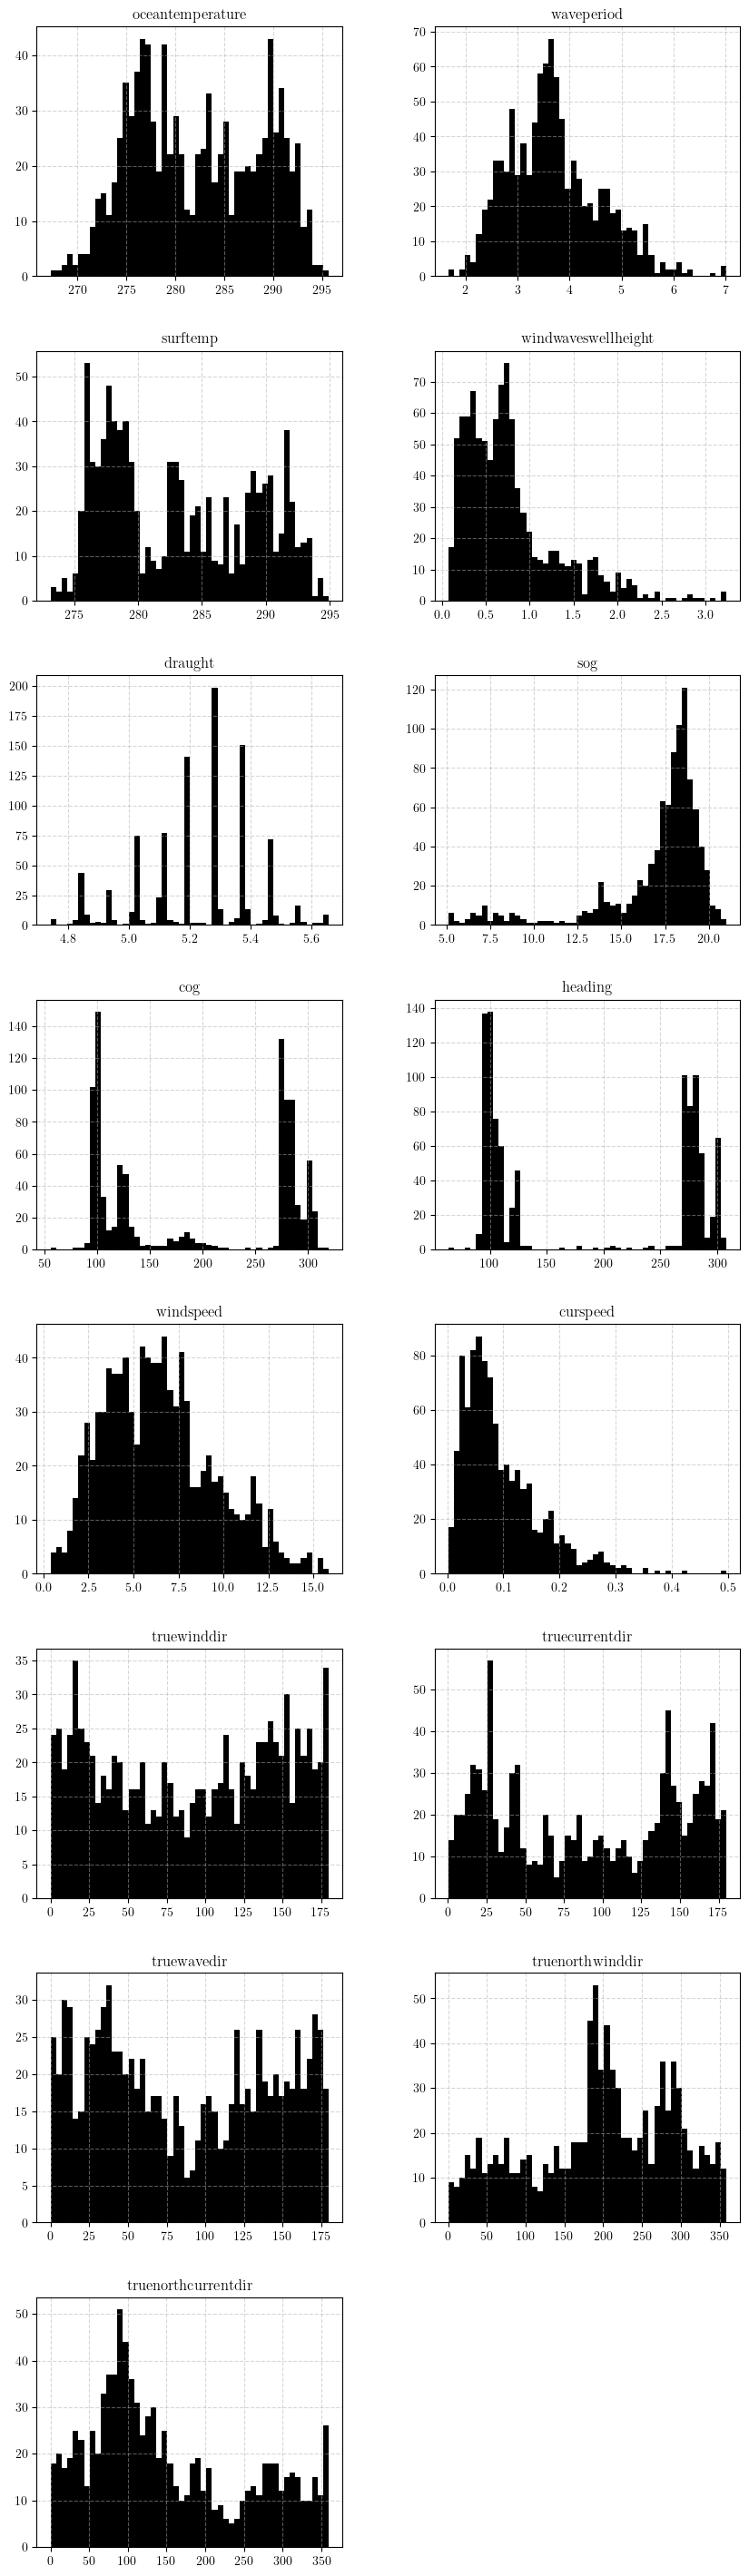

In [28]:
# plt.rcParams.update(plt.rcParamsDefault) # Alter default value 
axes = df_year_tr.hist(bins=50,figsize=(10,50),color='black',grid=True,layout=(11,2))
for ax in axes.flatten():
    ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [29]:
x_date_yr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,282.279440,3.697466,283.215909,0.771864,5.227477,196.729343,188.300965,6.450577,0.094795,91.397095,90.749781,86.903359
std,6.475851,0.879113,5.718259,0.541748,0.185996,86.724148,89.168377,3.047510,0.068851,56.239614,57.759771,55.737072
min,267.245300,1.672565,273.151367,0.075465,4.742534,56.023445,63.486661,0.398818,0.002006,0.029076,0.261234,0.055169
25%,276.796387,3.061307,277.980225,0.374414,5.109379,102.320635,100.855468,4.105194,0.045866,38.804565,31.517677,36.235065
50%,281.913574,3.616586,282.726074,0.662103,5.287457,185.223256,124.244421,6.126151,0.074553,95.245992,90.435400,81.540166
75%,288.423340,4.216455,288.822632,0.943902,5.377427,282.181107,279.379130,8.210403,0.128141,142.826897,144.654991,138.038714
max,295.699951,7.014300,294.928223,3.236886,5.657877,319.851509,308.035345,15.852335,0.497666,179.858625,179.952696,179.810480


In [30]:
stats_DSyear = x_date_yr.describe().transpose()
print(stats_DSyear.to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

))  

\begin{tabular}{rrrrrrrr}
\toprule
 count &   mean &   std &    min &    25\% &    50\% &    75\% &    max \\
\midrule
957.00 & 282.28 &  6.48 & 267.25 & 276.80 & 281.91 & 288.42 & 295.70 \\
957.00 &   3.70 &  0.88 &   1.67 &   3.06 &   3.62 &   4.22 &   7.01 \\
957.00 & 283.22 &  5.72 & 273.15 & 277.98 & 282.73 & 288.82 & 294.93 \\
957.00 &   0.77 &  0.54 &   0.08 &   0.37 &   0.66 &   0.94 &   3.24 \\
957.00 &   5.23 &  0.19 &   4.74 &   5.11 &   5.29 &   5.38 &   5.66 \\
957.00 & 196.73 & 86.72 &  56.02 & 102.32 & 185.22 & 282.18 & 319.85 \\
957.00 & 188.30 & 89.17 &  63.49 & 100.86 & 124.24 & 279.38 & 308.04 \\
957.00 &   6.45 &  3.05 &   0.40 &   4.11 &   6.13 &   8.21 &  15.85 \\
957.00 &   0.09 &  0.07 &   0.00 &   0.05 &   0.07 &   0.13 &   0.50 \\
957.00 &  91.40 & 56.24 &   0.03 &  38.80 &  95.25 & 142.83 & 179.86 \\
957.00 &  90.75 & 57.76 &   0.26 &  31.52 &  90.44 & 144.65 & 179.95 \\
957.00 &  86.90 & 55.74 &   0.06 &  36.24 &  81.54 & 138.04 & 179.81 \\
\bottomrule
\end{

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\243031061.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_DSyear.to_latex(index=False,


In [31]:
y_date_yr.describe()

count    957.000000
mean      16.992892
std        3.098953
min        5.104109
25%       16.682544
50%       18.054214
75%       18.716411
max       21.005331
Name: sog, dtype: float64

In [32]:
x_date_s.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,285.589553,3.729816,286.326507,0.817906,5.298229,196.058776,188.075527,6.638722,0.095515,90.944052,83.648221,88.060910
std,5.899112,0.992092,5.100742,0.628985,0.165597,87.546749,89.016268,3.327474,0.072561,58.052230,59.525944,59.519132
min,269.270386,2.019747,274.747070,0.084262,4.742534,56.023445,63.486661,0.398818,0.002006,0.598850,0.261234,0.090890
25%,282.898376,2.945056,283.051697,0.356768,5.199742,102.802789,100.752155,4.075977,0.042539,38.395213,26.684098,32.998854
50%,286.700684,3.601665,287.582764,0.670919,5.290759,182.786892,124.681623,6.303913,0.073974,89.864986,70.507662,82.181763
75%,290.039307,4.362177,290.184113,1.017011,5.381593,282.032566,278.068077,8.708087,0.132445,145.861449,143.729913,145.693518
max,295.699951,7.014300,294.928223,3.236886,5.657877,319.851509,303.295177,15.852335,0.497666,179.576603,179.325689,179.810480


In [33]:
stats_DSsummer = x_date_s.describe().transpose()
print(stats_DSsummer.to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

))  

\begin{tabular}{rrrrrrrr}
\toprule
 count &   mean &   std &    min &    25\% &    50\% &    75\% &    max \\
\midrule
454.00 & 285.59 &  5.90 & 269.27 & 282.90 & 286.70 & 290.04 & 295.70 \\
454.00 &   3.73 &  0.99 &   2.02 &   2.95 &   3.60 &   4.36 &   7.01 \\
454.00 & 286.33 &  5.10 & 274.75 & 283.05 & 287.58 & 290.18 & 294.93 \\
454.00 &   0.82 &  0.63 &   0.08 &   0.36 &   0.67 &   1.02 &   3.24 \\
454.00 &   5.30 &  0.17 &   4.74 &   5.20 &   5.29 &   5.38 &   5.66 \\
454.00 & 196.06 & 87.55 &  56.02 & 102.80 & 182.79 & 282.03 & 319.85 \\
454.00 & 188.08 & 89.02 &  63.49 & 100.75 & 124.68 & 278.07 & 303.30 \\
454.00 &   6.64 &  3.33 &   0.40 &   4.08 &   6.30 &   8.71 &  15.85 \\
454.00 &   0.10 &  0.07 &   0.00 &   0.04 &   0.07 &   0.13 &   0.50 \\
454.00 &  90.94 & 58.05 &   0.60 &  38.40 &  89.86 & 145.86 & 179.58 \\
454.00 &  83.65 & 59.53 &   0.26 &  26.68 &  70.51 & 143.73 & 179.33 \\
454.00 &  88.06 & 59.52 &   0.09 &  33.00 &  82.18 & 145.69 & 179.81 \\
\bottomrule
\end{

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\2468198302.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_DSsummer.to_latex(index=False,


In [34]:
y_date_s.describe()

count    454.000000
mean      17.264115
std        2.910371
min        5.224523
25%       16.740121
50%       18.172679
75%       18.949954
max       21.005331
Name: sog, dtype: float64

In [35]:
x_date_w.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,279.291783,3.668267,280.408332,0.730308,5.163618,197.334587,188.504441,6.280760,0.094145,91.806005,97.159540,85.858571
std,5.441286,0.762762,4.705698,0.445271,0.180340,86.057678,89.393560,2.763034,0.065388,54.606739,55.399755,52.126259
min,267.245300,1.672565,273.151367,0.075465,4.755055,80.805636,89.221494,0.427826,0.003022,0.029076,1.444688,0.055169
25%,275.740845,3.158122,277.230103,0.395192,5.020568,102.253912,100.874351,4.116934,0.048672,39.664718,41.918483,39.440544
50%,278.215088,3.620514,278.681885,0.656574,5.199700,187.556009,123.916325,6.047215,0.075327,97.923209,102.124889,81.222034
75%,281.254150,4.135854,282.679810,0.897899,5.289907,282.634606,280.047244,8.008357,0.124327,140.204666,145.342033,132.489514
max,292.722778,5.978095,292.849853,2.434368,5.654461,307.924559,308.035345,14.347213,0.418802,179.858625,179.952696,178.295216


In [36]:
stats_DSwinter = x_date_w.describe().transpose()
print(stats_DSwinter.to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

))  

\begin{tabular}{rrrrrrrr}
\toprule
 count &   mean &   std &    min &    25\% &    50\% &    75\% &    max \\
\midrule
503.00 & 279.29 &  5.44 & 267.25 & 275.74 & 278.22 & 281.25 & 292.72 \\
503.00 &   3.67 &  0.76 &   1.67 &   3.16 &   3.62 &   4.14 &   5.98 \\
503.00 & 280.41 &  4.71 & 273.15 & 277.23 & 278.68 & 282.68 & 292.85 \\
503.00 &   0.73 &  0.45 &   0.08 &   0.40 &   0.66 &   0.90 &   2.43 \\
503.00 &   5.16 &  0.18 &   4.76 &   5.02 &   5.20 &   5.29 &   5.65 \\
503.00 & 197.33 & 86.06 &  80.81 & 102.25 & 187.56 & 282.63 & 307.92 \\
503.00 & 188.50 & 89.39 &  89.22 & 100.87 & 123.92 & 280.05 & 308.04 \\
503.00 &   6.28 &  2.76 &   0.43 &   4.12 &   6.05 &   8.01 &  14.35 \\
503.00 &   0.09 &  0.07 &   0.00 &   0.05 &   0.08 &   0.12 &   0.42 \\
503.00 &  91.81 & 54.61 &   0.03 &  39.66 &  97.92 & 140.20 & 179.86 \\
503.00 &  97.16 & 55.40 &   1.44 &  41.92 & 102.12 & 145.34 & 179.95 \\
503.00 &  85.86 & 52.13 &   0.06 &  39.44 &  81.22 & 132.49 & 178.30 \\
\bottomrule
\end{

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\2440674044.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_DSwinter.to_latex(index=False,


In [37]:
y_date_w.describe()

count    503.000000
mean      16.748089
std        3.243255
min        5.104109
25%       16.593366
50%       17.977196
75%       18.612312
max       20.701952
Name: sog, dtype: float64

In [38]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()
    stadev_rsquared = score_r2.std()
    max_rsquared = score_r2.max()
    min_rsquared = score_r2.min()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()
    stadev_expVar = score_expVar.std()
    max_expVar = score_expVar.max()
    min_expVar = score_expVar.min()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()
    stadev_MAE = score_MAE.std()
    max_MAE = -score_MAE.max()
    min_MAE = -score_MAE.min()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()
    stadev_MAD = score_MAD.std()
    max_MAD = -score_MAD.max()
    min_MAD = -score_MAD.min()



    score_MSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    score_RMSE = np.sqrt(-score_MSE)
    RMSE = score_RMSE.mean()
    stadev_RMSE = score_RMSE.std()
    max_RMSE = score_RMSE.max()
    min_RMSE = score_RMSE.min()


    print(f"Model Performance of {model}")
    print(f"R^2 = {rsquared:0.4f}, std = {stadev_rsquared:0.4f}, max = {max_rsquared:0.4f}, min = {min_rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}, std = {stadev_expVar:0.4f}, max = {max_expVar:0.4f}, min = {min_expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}, std = {stadev_MAE:0.4f}, max = {max_MAE:0.4f}, min = {min_MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}, std = {stadev_RMSE:0.4f}, max = {max_RMSE:0.4f}, min = {min_RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}, std = {stadev_MAD:0.4f}, max = {max_MAD:0.4f}, min = {min_MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_RMSE,score_MAD    

RFR evaluation

In [39]:
# # Model performance for one year test data

# r2_rfo_yr,expVar_rfo_yr,MAE_rfo_yr,RMSE_rfo_yr,MAD_rfo_yr = evaluate(model_rfr_hpov,x_date_yr,y_date_yr)

In [40]:
# # Model performance for winter test data

# r2_rfo_w,expVar_rfo_w,MAE_rfo_w,RMSE_rfo_w,MAD_rfo_w = evaluate(model_rfr_hpov,x_date_w,y_date_w)

In [41]:
# # Model performance for summer test data

# r2_rfo_s,expVar_rfo_s,MAE_rfo_s,RMSE_rfo_s,MAD_rfo_s = evaluate(model_rfr_hpov,x_date_s,y_date_s)

ETR evaluation

In [42]:
# # Model performance for one year test data

# r2_eto_yr,expVar_eto_yr,MAE_eto_yr,RMSE_eto_yr,MAD_eto_yr = evaluate(model_etr_hpov,x_date_yr,y_date_yr)

In [43]:
# # Model performance for winter test data

# r2_eto_w,expVar_eto_w,MAE_eto_w,RMSE_eto_w,MAD_eto_w = evaluate(model_etr_hpov,x_date_w,y_date_w)

In [44]:
# # Model performance for summer test data

# r2_eto_s,expVar_eto_s,MAE_eto_s,RMSE_eto_s,MAD_eto_s = evaluate(model_etr_hpov,x_date_s,y_date_s)

DT evaluation

In [45]:
# r2_dto_yr,expVar_dto_yr,MAE_dto_yr,RMSE_dto_yr,MAD_dto_yr = evaluate(model_dtr_hpov,x_date_yr,y_date_yr)

In [46]:
# r2_dto_w,expVar_dto_w,MAE_dto_w,RMSE_dto_w,MAD_dto_w = evaluate(model_dtr_hpov,x_date_w,y_date_w)

In [47]:
# r2_dto_s,expVar_dto_s,MAE_dto_s,RMSE_dto_s,MAD_dto_s = evaluate(model_dtr_hpov,x_date_s,y_date_s)

ML evaluation

In [48]:
# r2_mlr_yr,expVar_mlr_yr,MAE_mlr_yr,RMSE_mlr_yr,MAD_mlr_yr = evaluate(model_mlr_ftr,x_date_yr,y_date_yr)

In [49]:
# r2_mlr_w,expVar_mlr_w,MAE_mlr_w,RMSE_mlr_w,MAD_mlr_w = evaluate(model_mlr_ftr,x_date_w,y_date_w)

In [50]:
# r2_mlr_s,expVar_mlr_s,MAE_mlr_s,RMSE_mlr_s,MAD_mlr_s = evaluate(model_mlr_ftr,x_date_s,y_date_s)

In [51]:
def evaluate_SOG(model,x_date,y_date):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    def label_predict(model,test_features):
        predictions = model.predict(test_features)
        return predictions
    
    predictions = label_predict(model,x_date)

    Rsquared_SOG = r2_score(y_date,predictions)
    expVar_SOG = explained_variance_score(y_date,predictions)
    MAE_SOG = mean_absolute_error(y_date,predictions)
    RMSE_SOG = np.sqrt(mean_squared_error(y_date, predictions))
    MAD_SOG = median_absolute_error(y_date,predictions)
    MAPE_SOG = mean_absolute_percentage_error(y_date, predictions)
    

    print(f"Model Performance of {model}")
    print(f"R^2 SOG = {Rsquared_SOG:0.4f}")
    print(f"Explained Variance SOG = {expVar_SOG:0.4f}")
    print(f"MSE SOG = {MAE_SOG:0.4f} Knots")    
    print(f"RMSE SOG = {RMSE_SOG:0.4f} Knots")
    print(f"MAD SOG = {MAD_SOG:0.4f} Knots")    
    print(f"MAPE SOG = {MAPE_SOG*100:0.4f} %")

Check absolute performance of the model on test data

ETR

In [52]:
# Year dataset
evaluate_SOG(model_etr_hpov,x_date_yr,y_date_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9190
Explained Variance SOG = 0.9191
MSE SOG = 0.5819 Knots
RMSE SOG = 0.8816 Knots
MAD SOG = 0.3975 Knots
MAPE SOG = 3.9619 %


In [53]:
evaluate_SOG(model_etr_hpov,x_date_w,y_date_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9455
Explained Variance SOG = 0.9463
MSE SOG = 0.5324 Knots
RMSE SOG = 0.7563 Knots
MAD SOG = 0.3943 Knots
MAPE SOG = 3.7242 %


In [54]:
evaluate_SOG(model_etr_hpov,x_date_s,y_date_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.8811
Explained Variance SOG = 0.8813
MSE SOG = 0.6368 Knots
RMSE SOG = 1.0023 Knots
MAD SOG = 0.4089 Knots
MAPE SOG = 4.2253 %


RFR

In [55]:
evaluate_SOG(model_rfr_hpov,x_date_yr,y_date_yr)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9013
Explained Variance SOG = 0.9016
MSE SOG = 0.6187 Knots
RMSE SOG = 0.9729 Knots
MAD SOG = 0.4188 Knots
MAPE SOG = 4.2917 %


In [56]:
evaluate_SOG(model_rfr_hpov,x_date_w,y_date_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9340
Explained Variance SOG = 0.9352
MSE SOG = 0.5494 Knots
RMSE SOG = 0.8325 Knots
MAD SOG = 0.3739 Knots
MAPE SOG = 3.9604 %


In [57]:
evaluate_SOG(model_rfr_hpov,x_date_s,y_date_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.8548
Explained Variance SOG = 0.8548
MSE SOG = 0.6955 Knots
RMSE SOG = 1.1079 Knots
MAD SOG = 0.4546 Knots
MAPE SOG = 4.6588 %


DTR


In [58]:
evaluate_SOG(model_dtr_hpov,x_date_yr,y_date_yr)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.8672
Explained Variance SOG = 0.8675
MSE SOG = 0.7141 Knots
RMSE SOG = 1.1285 Knots
MAD SOG = 0.4794 Knots
MAPE SOG = 4.9554 %


In [59]:
evaluate_SOG(model_dtr_hpov,x_date_w,y_date_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.8851
Explained Variance SOG = 0.8861
MSE SOG = 0.6900 Knots
RMSE SOG = 1.0981 Knots
MAD SOG = 0.4410 Knots
MAPE SOG = 4.9453 %


In [60]:
evaluate_SOG(model_dtr_hpov,x_date_s,y_date_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.8404
Explained Variance SOG = 0.8405
MSE SOG = 0.7408 Knots
RMSE SOG = 1.1613 Knots
MAD SOG = 0.5197 Knots
MAPE SOG = 4.9667 %


MLR

In [61]:
evaluate_SOG(model_mlr_ftr,x_date_yr,y_date_yr)

Model Performance of LinearRegression()
R^2 SOG = 0.6961
Explained Variance SOG = 0.6967
MSE SOG = 1.1467 Knots
RMSE SOG = 1.7076 Knots
MAD SOG = 0.9244 Knots
MAPE SOG = 7.7331 %


In [62]:
evaluate_SOG(model_mlr_ftr,x_date_s,y_date_s)

Model Performance of LinearRegression()
R^2 SOG = 0.7121
Explained Variance SOG = 0.7156
MSE SOG = 1.1595 Knots
RMSE SOG = 1.5599 Knots
MAD SOG = 0.9487 Knots
MAPE SOG = 7.3893 %


In [63]:
evaluate_SOG(model_mlr_ftr,x_date_w,y_date_w)

Model Performance of LinearRegression()
R^2 SOG = 0.6808
Explained Variance SOG = 0.6808
MSE SOG = 1.1351 Knots
RMSE SOG = 1.8306 Knots
MAD SOG = 0.8803 Knots
MAPE SOG = 8.0434 %


In [64]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.3f}x {b:+.3f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$kts$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$kts$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend()



0.8672464976207171
y = 0.9 * x + 2.2
0.9013298880796538
y = 0.9 * x + 2.0


0.9189869722041056
y = 0.9 * x + 1.9


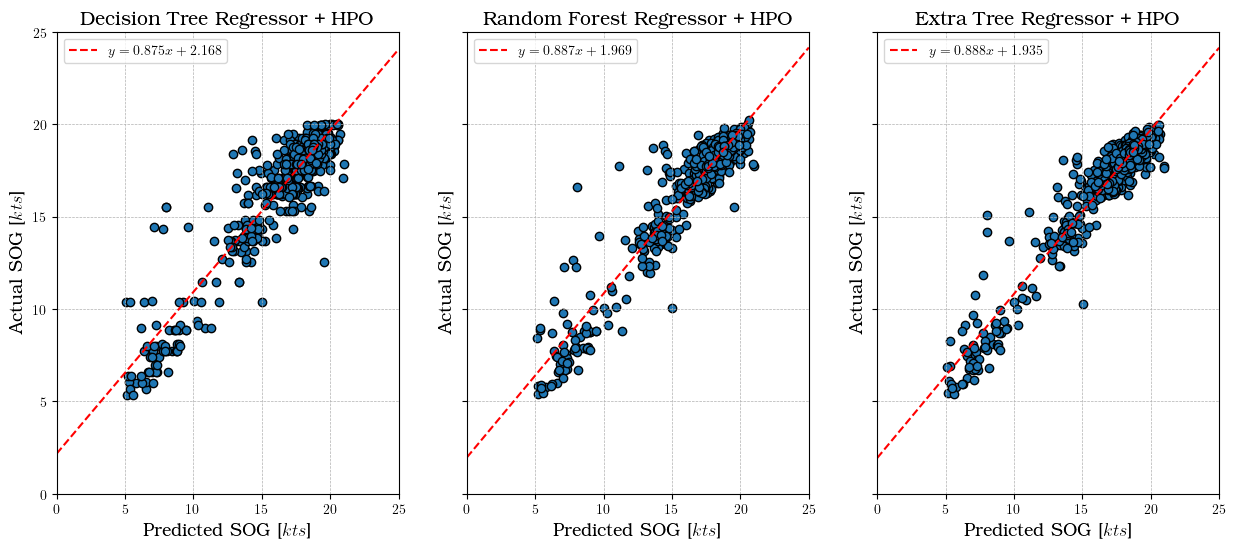

In [65]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.sca(axes[2])
pred_plot(model_etr_hpov,'Extra Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.show()

0.817360398164716
y = 0.9 * x + 1.7
0.8672464976207171
y = 0.9 * x + 2.2


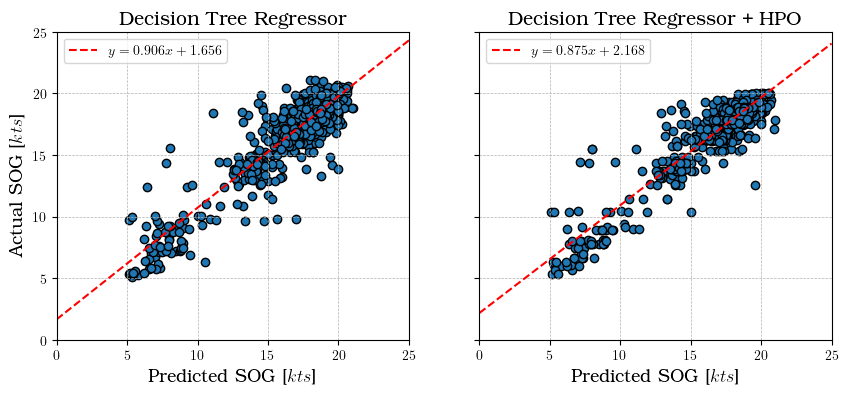

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_ftr,'Decision Tree Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.8931547212387919
y = 0.9 * x + 2.0
0.9013298880796538
y = 0.9 * x + 2.0


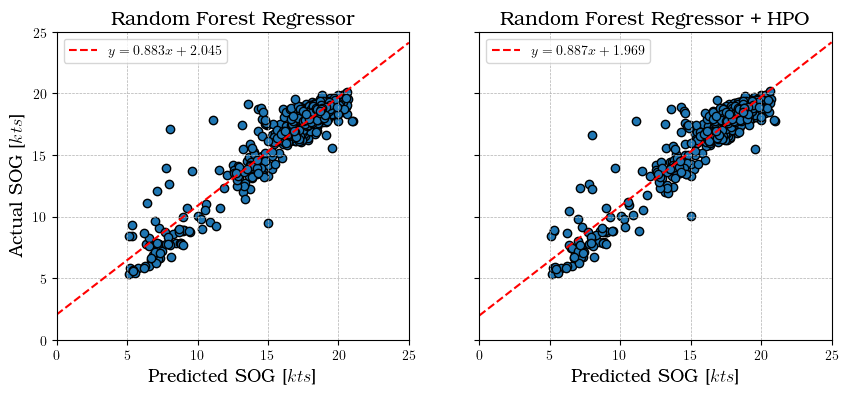

In [67]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_rfr_ftr,'Random Forest Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.9231776771575881
y = 0.9 * x + 1.8
0.9189869722041056
y = 0.9 * x + 1.9


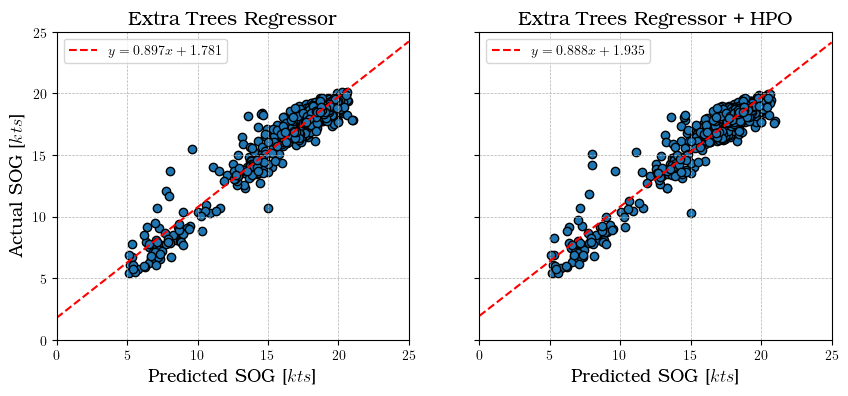

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_etr,'Extra Trees Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_etr_hpov,'Extra Trees Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

Evaluation using Cross Validation

In [69]:
# scores_test = [r2_rf,r2_et,r2_dt,r2_mlr]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# # ax = fig.add_axes([0, 0, 1, 1])
# fig,ax = plt.subplots()
# plt.title("Validation Data Model Performance")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0.2,1.0)
# plt.boxplot(scores_test,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels(['RFR', 'ETR',
#                     'DTR','MLR'])
# plt.show()

In [70]:
# scores_test = [-RMSE_rf,-RMSE_et,-RMSE_dt,-RMSE_mlr]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# # ax = fig.add_axes([0, 0, 1, 1])
# fig,ax = plt.subplots()
# plt.title("Validation Data Model Performance")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,1.6)
# plt.boxplot(scores_test,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels(['RFR', 'ETR',
#                     'DTR','MLR'])
# plt.show()

Optimization comparison

In [71]:
# scores_opt = [r2_rfo_s,r2_rfo_w,r2_eto_s,r2_eto_w,r2_dto_s,r2_dto_w]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Optimized Model on Test Dataset Performance")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.ylim(0.2,1.0)
# plt.yscale('linear')
# ax.boxplot(scores_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'$RFR_{sum}$', r'$RFR_{win}$',
#                     r'$ETR_{sum}$', r'$ETR_{win}$',
#                     r'$DTR_{sum}$',r'$DTR_{win}$'])
# plt.show()

In [72]:
# rmse_opt = [RMSE_rfo_s,RMSE_rfo_w,RMSE_eto_s,RMSE_eto_w,RMSE_dto_s,RMSE_dto_w]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Optimized Model Performance")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,2)
# ax.boxplot(rmse_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'$RFR_{sum}$', r'$RFR_{win}$',
#                     r'$ETR_{sum}$', r'$ETR_{win}$',
#                     r'$DTR_{sum}$',r'$DTR_{win}$'])
# plt.show()

In [73]:
# scores_opt = [r2_rf,r2_rfc,r2_et,r2_etc,r2_dt,r2_dtc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Impact of amount of data")
# plt.ylabel("R-squared")
# plt.xlabel("Model")
# plt.ylim(0.2,1.0)
# plt.yscale('linear')
# ax.boxplot(scores_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
#                     r'ETR', r'$ETR_{6mths}$',
#                     r'DTR',r'$DTR_{6mths}$'])
# plt.show()

In [74]:
# rmse_opt = [-RMSE_rf,-RMSE_rfc,-RMSE_et,-RMSE_etc,-RMSE_dt,-RMSE_dtc]
# fig = plt.figure(figsize=(5,3))
# # Creating axes instance
# fig,ax = plt.subplots() 
# plt.title("Impact of Amount of Data")
# plt.ylabel("RMSE")
# plt.xlabel("Model")
# plt.yscale('linear')
# plt.ylim(0,1.6)
# ax.boxplot(rmse_opt,showmeans=True)
# plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
# ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
#                     r'ETR', r'$ETR_{6mths}$',
#                     r'DTR',r'$DTR_{6mths}$'])
# plt.show()

In [75]:
# # define the true objective function
# def objective(x, a, b, c):
# 	return a * x + b * x**2 + c

STW Calculation

In [76]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

#Test data

# ETR
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)

# RFR
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)


# DTR
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)

# MLR  
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
ydate_pred__mlr_yr = label_predict(model_mlr_ftr,x_date_yr)


# For actual results

# Yearly dataset

dfprog_sog_yr = pd.Series(y_date_yr,name="sog_act_yr").to_frame()
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)
ydate_pred_mlr_yr = label_predict(model_mlr_ftr,x_date_yr)
dfprog_sog_yr["sog_pred_yr"] = ydate_pred_yr
dfprog_sog_yr["sog_pred_rf_yr"] = ydate_pred_rf_yr
dfprog_sog_yr["sog_pred_dt_yr"] = ydate_pred_dt_yr
dfprog_sog_yr["sog_pred_mlr_yr"] = ydate_pred_mlr_yr
dfprog_sog_yr["gamma_yr"] = df_year_tr["truenorthcurrentdir"]
dfprog_sog_yr["nwinddir_yr"] = df_year_tr["truenorthwinddir"]
dfprog_yr = pd.concat([x_date_yr,dfprog_sog_yr],axis=1)


# Winter dataset
dfprog_sog_w = pd.Series(y_date_w,name="sog_act_w").to_frame()
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
dfprog_sog_w["sog_pred_w"] = ydate_pred_w
dfprog_sog_w["sog_pred_rf_w"] = ydate_pred_rf_w
dfprog_sog_w["sog_pred_dt_w"] = ydate_pred_dt_w
dfprog_sog_w["sog_pred_mlr_w"] = ydate_pred_mlr_w
dfprog_sog_w["gamma_w"] = df_winter_tr["truenorthcurrentdir"]
dfprog_sog_w["nwinddir_w"] = df_winter_tr["truenorthwinddir"]
dfprog_w = pd.concat([x_date_w,dfprog_sog_w],axis=1)

# Summer Dataset
dfprog_sog_s = pd.Series(y_date_s,name="sog_act_s").to_frame()
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
dfprog_sog_s["sog_pred_s"] = ydate_pred_s
dfprog_sog_s["sog_pred_rf_s"] = ydate_pred_rf_s
dfprog_sog_s["sog_pred_dt_s"] = ydate_pred_dt_s
dfprog_sog_s["sog_pred_mlr_s"] = ydate_pred_mlr_s
dfprog_sog_s["gamma_s"] = df_summer_tr["truenorthcurrentdir"]
dfprog_sog_s["nwinddir_s"] = df_summer_tr["truenorthwinddir"]
dfprog_s = pd.concat([x_date_s,dfprog_sog_s],axis=1)




# dfprog_sog = pd.Series(y_date_s,name="sog_act_s").to_frame()
# dfprog_sog["sog_act_w"] = y_date_w
# #ETR
# dfprog_sog["sog_pred_s"] = ydate_pred_s
# dfprog_sog["sog_pred_w"] = ydate_pred_w
# #RFR
# dfprog_sog["sog_pred_rf_s"] = ydate_pred_rf_s
# dfprog_sog["sog_pred_rf_w"] = ydate_pred_rf_w
# #DTR
# dfprog_sog["sog_pred_dt_s"] = ydate_pred_dt_s
# dfprog_sog["sog_pred_dt_s"] = ydate_pred_dt_s
# #MLR one year
# dfprog_sog["sog_pred_mlr"] = ydate_pred_mlr
# #Current wind direction summer winter
# dfprog_sog["gamma_s"] = df_summer_tr["truenorthcurrentdir"]
# dfprog_sog["gamma_w"] = df_winter_tr["truenorthcurrentdir"]
# dfprog_sog["nwinddir_s"] = df_summer_tr["truenorthwinddir"]
# dfprog_sog["nwinddir_s"] = df_summer_tr["truenorthwinddir"]

# dfprog = pd.concat([x_date,dfprog_sog],axis=1)
# print(dfprog_sog)

In [77]:
dfprog_yr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_yr,sog_pred_yr,sog_pred_rf_yr,sog_pred_dt_yr,sog_pred_mlr_yr,gamma_yr,nwinddir_yr
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,282.279440,3.697466,283.215909,0.771864,5.227477,196.729343,188.300965,6.450577,0.094795,91.397095,90.749781,86.903359,16.992892,17.025269,17.043764,17.039383,16.917337,152.594366,198.620460
std,6.475851,0.879113,5.718259,0.541748,0.185996,86.724148,89.168377,3.047510,0.068851,56.239614,57.759771,55.737072,3.098953,2.868771,2.894956,2.911714,2.479045,100.468944,91.556109
min,267.245300,1.672565,273.151367,0.075465,4.742534,56.023445,63.486661,0.398818,0.002006,0.029076,0.261234,0.055169,5.104109,5.392064,5.374645,5.361528,4.519637,0.335373,0.232451
25%,276.796387,3.061307,277.980225,0.374414,5.109379,102.320635,100.855468,4.105194,0.045866,38.804565,31.517677,36.235065,16.682544,16.669291,16.713103,16.578242,17.166503,77.207028,139.551166
50%,281.913574,3.616586,282.726074,0.662103,5.287457,185.223256,124.244421,6.126151,0.074553,95.245992,90.435400,81.540166,18.054214,18.054795,18.109655,18.112733,17.668134,123.761356,203.575325
75%,288.423340,4.216455,288.822632,0.943902,5.377427,282.181107,279.379130,8.210403,0.128141,142.826897,144.654991,138.038714,18.716411,18.645150,18.700514,18.664988,17.980922,231.331274,274.642505
max,295.699951,7.014300,294.928223,3.236886,5.657877,319.851509,308.035345,15.852335,0.497666,179.858625,179.952696,179.810480,21.005331,19.960362,20.216676,19.996240,24.084871,359.450078,358.907188


In [78]:
dfprog_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503 entries, 6981 to 2163
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     503 non-null    float64
 1   waveperiod           503 non-null    float64
 2   surftemp             503 non-null    float64
 3   windwaveswellheight  503 non-null    float64
 4   draught              503 non-null    float64
 5   cog                  503 non-null    float64
 6   heading              503 non-null    float64
 7   windspeed            503 non-null    float64
 8   curspeed             503 non-null    float64
 9   truewinddir          503 non-null    float64
 10  truecurrentdir       503 non-null    float64
 11  truewavedir          503 non-null    float64
 12  sog_act_w            503 non-null    float64
 13  sog_pred_w           503 non-null    float64
 14  sog_pred_rf_w        503 non-null    float64
 15  sog_pred_dt_w        503 non-null   

In [79]:
dfprog_w.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_w,sog_pred_w,sog_pred_rf_w,sog_pred_dt_w,sog_pred_mlr_w,gamma_w,nwinddir_w
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,279.291783,3.668267,280.408332,0.730308,5.163618,197.334587,188.504441,6.280760,0.094145,91.806005,97.159540,85.858571,16.748089,16.837469,16.860896,16.849673,16.760333,152.756617,203.426871
std,5.441286,0.762762,4.705698,0.445271,0.180340,86.057678,89.393560,2.763034,0.065388,54.606739,55.399755,52.126259,3.243255,3.038482,3.035970,3.058147,2.656057,100.407252,94.158165
min,267.245300,1.672565,273.151367,0.075465,4.755055,80.805636,89.221494,0.427826,0.003022,0.029076,1.444688,0.055169,5.104109,5.392064,5.374645,5.361528,4.519637,0.335373,0.232451
25%,275.740845,3.158122,277.230103,0.395192,5.020568,102.253912,100.874351,4.116934,0.048672,39.664718,41.918483,39.440544,16.593366,16.648277,16.701903,16.578242,17.004997,78.133231,147.858709
50%,278.215088,3.620514,278.681885,0.656574,5.199700,187.556009,123.916325,6.047215,0.075327,97.923209,102.124889,81.222034,17.977196,17.960978,18.017749,17.858925,17.525937,122.967211,205.983056
75%,281.254150,4.135854,282.679810,0.897899,5.289907,282.634606,280.047244,8.008357,0.124327,140.204666,145.342033,132.489514,18.612312,18.560657,18.598628,18.578152,17.905447,225.131044,280.202556
max,292.722778,5.978095,292.849853,2.434368,5.654461,307.924559,308.035345,14.347213,0.418802,179.858625,179.952696,178.295216,20.701952,19.865482,19.735113,19.977031,24.084871,359.264290,358.907188


In [80]:
dfprog_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454 entries, 3198 to 6341
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     454 non-null    float64
 1   waveperiod           454 non-null    float64
 2   surftemp             454 non-null    float64
 3   windwaveswellheight  454 non-null    float64
 4   draught              454 non-null    float64
 5   cog                  454 non-null    float64
 6   heading              454 non-null    float64
 7   windspeed            454 non-null    float64
 8   curspeed             454 non-null    float64
 9   truewinddir          454 non-null    float64
 10  truecurrentdir       454 non-null    float64
 11  truewavedir          454 non-null    float64
 12  sog_act_s            454 non-null    float64
 13  sog_pred_s           454 non-null    float64
 14  sog_pred_rf_s        454 non-null    float64
 15  sog_pred_dt_s        454 non-null   

In [81]:
dfprog_s.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_s,sog_pred_s,sog_pred_rf_s,sog_pred_dt_s,sog_pred_mlr_s,gamma_s,nwinddir_s
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,285.589553,3.729816,286.326507,0.817906,5.298229,196.058776,188.075527,6.638722,0.095515,90.944052,83.648221,88.060910,17.264115,17.233338,17.246370,17.249567,17.091287,152.414603,193.295295
std,5.899112,0.992092,5.100742,0.628985,0.165597,87.546749,89.016268,3.327474,0.072561,58.052230,59.525944,59.519132,2.910371,2.656030,2.719227,2.728334,2.257041,100.647716,88.382376
min,269.270386,2.019747,274.747070,0.084262,4.742534,56.023445,63.486661,0.398818,0.002006,0.598850,0.261234,0.090890,5.224523,5.958221,5.808774,5.641931,4.783272,2.677540,1.098283
25%,282.898376,2.945056,283.051697,0.356768,5.199742,102.802789,100.752155,4.075977,0.042539,38.395213,26.684098,32.998854,16.740121,16.706790,16.735144,16.578242,17.289837,77.014658,135.047483
50%,286.700684,3.601665,287.582764,0.670919,5.290759,182.786892,124.681623,6.303913,0.073974,89.864986,70.507662,82.181763,18.172679,18.176979,18.201923,18.154850,17.761574,124.240301,201.288368
75%,290.039307,4.362177,290.184113,1.017011,5.381593,282.032566,278.068077,8.708087,0.132445,145.861449,143.729913,145.693518,18.949954,18.745138,18.772637,18.907098,18.025349,236.190471,270.937591
max,295.699951,7.014300,294.928223,3.236886,5.657877,319.851509,303.295177,15.852335,0.497666,179.576603,179.325689,179.810480,21.005331,19.960362,20.216676,19.996240,19.905067,359.450078,358.771465


In [82]:
print(dfprog_sog_s.describe())
print(dfprog_sog_s.describe().transpose().to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

))  

        sog_act_s  sog_pred_s  sog_pred_rf_s  sog_pred_dt_s  sog_pred_mlr_s  \
count  454.000000  454.000000     454.000000     454.000000      454.000000   
mean    17.264115   17.233338      17.246370      17.249567       17.091287   
std      2.910371    2.656030       2.719227       2.728334        2.257041   
min      5.224523    5.958221       5.808774       5.641931        4.783272   
25%     16.740121   16.706790      16.735144      16.578242       17.289837   
50%     18.172679   18.176979      18.201923      18.154850       17.761574   
75%     18.949954   18.745138      18.772637      18.907098       18.025349   
max     21.005331   19.960362      20.216676      19.996240       19.905067   

          gamma_s  nwinddir_s  
count  454.000000  454.000000  
mean   152.414603  193.295295  
std    100.647716   88.382376  
min      2.677540    1.098283  
25%     77.014658  135.047483  
50%    124.240301  201.288368  
75%    236.190471  270.937591  
max    359.450078  358.771465  


C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\2514083402.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfprog_sog_s.describe().transpose().to_latex(index=False,


<Figure size 500x300 with 0 Axes>

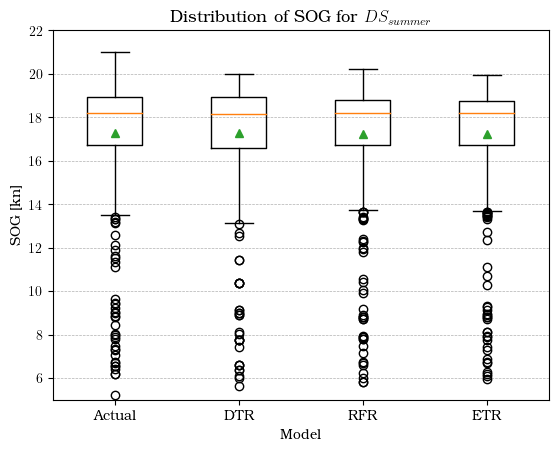

In [83]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_s['sog_act_s'],dfprog_sog_s['sog_pred_dt_s'],dfprog_sog_s['sog_pred_rf_s'],dfprog_sog_s['sog_pred_s']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{summer}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [84]:
print(dfprog_sog_w.describe())
print(dfprog_sog_w.describe().transpose().to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

)) 

        sog_act_w  sog_pred_w  sog_pred_rf_w  sog_pred_dt_w  sog_pred_mlr_w  \
count  503.000000  503.000000     503.000000     503.000000      503.000000   
mean    16.748089   16.837469      16.860896      16.849673       16.760333   
std      3.243255    3.038482       3.035970       3.058147        2.656057   
min      5.104109    5.392064       5.374645       5.361528        4.519637   
25%     16.593366   16.648277      16.701903      16.578242       17.004997   
50%     17.977196   17.960978      18.017749      17.858925       17.525937   
75%     18.612312   18.560657      18.598628      18.578152       17.905447   
max     20.701952   19.865482      19.735113      19.977031       24.084871   

          gamma_w  nwinddir_w  
count  503.000000  503.000000  
mean   152.756617  203.426871  
std    100.407252   94.158165  
min      0.335373    0.232451  
25%     78.133231  147.858709  
50%    122.967211  205.983056  
75%    225.131044  280.202556  
max    359.264290  358.907188  


C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\3151661830.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfprog_sog_w.describe().transpose().to_latex(index=False,


<Figure size 500x300 with 0 Axes>

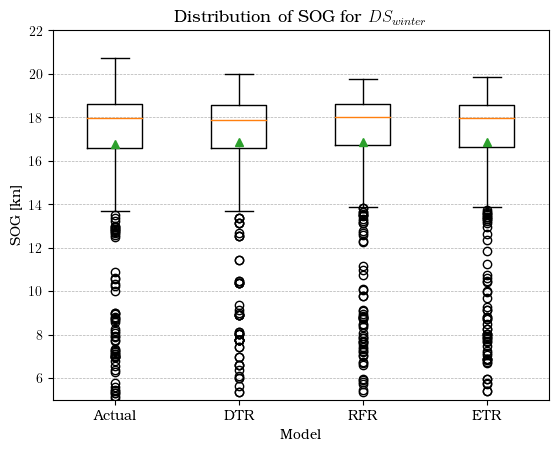

In [85]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_w['sog_act_w'],dfprog_sog_w['sog_pred_dt_w'],dfprog_sog_w['sog_pred_rf_w'],dfprog_sog_w['sog_pred_w']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{winter}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [86]:
print(dfprog_sog_yr.describe())
print(dfprog_sog_yr.describe().transpose().to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,

)) 

       sog_act_yr  sog_pred_yr  sog_pred_rf_yr  sog_pred_dt_yr  \
count  957.000000   957.000000      957.000000      957.000000   
mean    16.992892    17.025269       17.043764       17.039383   
std      3.098953     2.868771        2.894956        2.911714   
min      5.104109     5.392064        5.374645        5.361528   
25%     16.682544    16.669291       16.713103       16.578242   
50%     18.054214    18.054795       18.109655       18.112733   
75%     18.716411    18.645150       18.700514       18.664988   
max     21.005331    19.960362       20.216676       19.996240   

       sog_pred_mlr_yr    gamma_yr  nwinddir_yr  
count       957.000000  957.000000   957.000000  
mean         16.917337  152.594366   198.620460  
std           2.479045  100.468944    91.556109  
min           4.519637    0.335373     0.232451  
25%          17.166503   77.207028   139.551166  
50%          17.668134  123.761356   203.575325  
75%          17.980922  231.331274   274.642505  
max  

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\2854589879.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dfprog_sog_yr.describe().transpose().to_latex(index=False,


<Figure size 500x300 with 0 Axes>

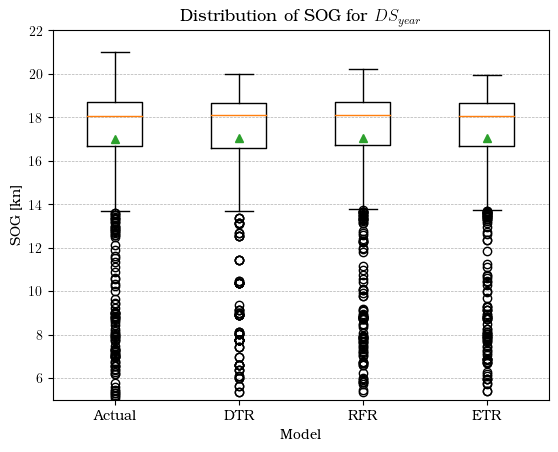

In [87]:
# Box plot of predicted results of yearly dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_yr['sog_act_yr'],dfprog_sog_yr['sog_pred_dt_yr'],dfprog_sog_yr['sog_pred_rf_yr'],dfprog_sog_yr['sog_pred_yr']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{year}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [88]:
def sog_corr(sog,gamma,heading,current_speed):
    # Conversion of predicted SOG to m/s
    vgms = sog/1.9438
    rad_gamma = np.deg2rad(gamma)
    rad_cog = np.deg2rad(heading)
    # Calculation of the predicted x-component of SOG

    vgx = vgms * np.sin(rad_cog)
    vcx = current_speed * np.sin(rad_gamma)
    stw_x = vgx - vcx

    # Calculation of the predicted y-component of SOG 

    vgy = vgms * np.cos(rad_cog)
    vcy = current_speed * rad_gamma
    stw_y = vgy - vcy

    vwms_p = np.sqrt(stw_x**2 + stw_y**2)
    stw_pred = vwms_p*1.9438

    return stw_pred

In [89]:
# STW conversion Year

# Actual
stw_act_yr = sog_corr(dfprog_yr['sog_act_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_act_yr'] = stw_act_yr
# ETR
stw_pred_et_yr = sog_corr(dfprog_yr['sog_pred_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_yr'] = stw_pred_et_yr
# RFR
stw_pred_rf_yr = sog_corr(dfprog_yr['sog_pred_rf_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_rf_yr'] = stw_pred_rf_yr
# DTR
stw_pred_dt_yr = sog_corr(dfprog_yr['sog_pred_dt_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_dt_yr'] = stw_pred_dt_yr
# MLR
stw_pred_mlr_yr = sog_corr(dfprog_yr['sog_pred_mlr_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_mlr_yr'] = stw_pred_mlr_yr



In [90]:
print(dfprog_yr.describe())

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        957.000000  957.000000  957.000000           957.000000   
mean         282.279440    3.697466  283.215909             0.771864   
std            6.475851    0.879113    5.718259             0.541748   
min          267.245300    1.672565  273.151367             0.075465   
25%          276.796387    3.061307  277.980225             0.374414   
50%          281.913574    3.616586  282.726074             0.662103   
75%          288.423340    4.216455  288.822632             0.943902   
max          295.699951    7.014300  294.928223             3.236886   

          draught         cog     heading   windspeed    curspeed  \
count  957.000000  957.000000  957.000000  957.000000  957.000000   
mean     5.227477  196.729343  188.300965    6.450577    0.094795   
std      0.185996   86.724148   89.168377    3.047510    0.068851   
min      4.742534   56.023445   63.486661    0.398818    0.002006   
25%   

In [91]:
# STW conversion Summer 

# Actual
stw_act_s = sog_corr(dfprog_s['sog_act_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_act_s'] = stw_act_s
# ETR
stw_pred_et_s = sog_corr(dfprog_s['sog_pred_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_s'] = stw_pred_et_s
# RFR
stw_pred_rf_s = sog_corr(dfprog_s['sog_pred_rf_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_rf_s'] = stw_pred_rf_s
# DTR
stw_pred_dt_s = sog_corr(dfprog_s['sog_pred_dt_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_dt_s'] = stw_pred_dt_s
# MLR
stw_pred_mlr_s = sog_corr(dfprog_s['sog_pred_mlr_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_mlr_s'] = stw_pred_mlr_s



In [92]:
print(dfprog_s.describe())

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        454.000000  454.000000  454.000000           454.000000   
mean         285.589553    3.729816  286.326507             0.817906   
std            5.899112    0.992092    5.100742             0.628985   
min          269.270386    2.019747  274.747070             0.084262   
25%          282.898376    2.945056  283.051697             0.356768   
50%          286.700684    3.601665  287.582764             0.670919   
75%          290.039307    4.362177  290.184113             1.017011   
max          295.699951    7.014300  294.928223             3.236886   

          draught         cog     heading   windspeed    curspeed  \
count  454.000000  454.000000  454.000000  454.000000  454.000000   
mean     5.298229  196.058776  188.075527    6.638722    0.095515   
std      0.165597   87.546749   89.016268    3.327474    0.072561   
min      4.742534   56.023445   63.486661    0.398818    0.002006   
25%   

In [93]:
# STW conversion Winter

# Actual
stw_act_w = sog_corr(dfprog_w['sog_act_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_act_w'] = stw_act_w
# ETR
stw_pred_et_w = sog_corr(dfprog_w['sog_pred_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_w'] = stw_pred_et_w
# RFR
stw_pred_rf_w = sog_corr(dfprog_w['sog_pred_rf_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_rf_w'] = stw_pred_rf_w
# DTR
stw_pred_dt_w = sog_corr(dfprog_w['sog_pred_dt_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_dt_w'] = stw_pred_dt_w
# MLR
stw_pred_mlr_w = sog_corr(dfprog_w['sog_pred_mlr_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_mlr_w'] = stw_pred_mlr_w

In [94]:
# # Predicted SOG from RF model

# stw_pred_rf = sog_corr(dfprog_sog['sog_pred_rf'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_pred_rf'] = stw_pred_rf

In [95]:
# # Predicted SOG from DT model

# stw_pred_dt = sog_corr(dfprog_sog['sog_pred_dt'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_pred_dt'] = stw_pred_dt

In [96]:
# # Predicted SOG from MLR model

# stw_pred_mlr = sog_corr(dfprog_sog['sog_pred_mlr'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_pred_mlr'] = stw_pred_mlr

In [97]:
# # Actual SOG

# stw_pred_act = sog_corr(dfprog_sog['sog_act'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

# dfprog['stw_act'] = stw_pred_act

In [98]:
# dfprog.describe()

Holtrop Mennen FOC function

In [99]:
def foc_fun(stw,T_dyn,windspeed,truewindir,H_s,truewavedir):
    # Ship Information, that are readily available in ship specification
    loa = 158 # ship overall length
    lwl = 144.8 # ship waterline length, m
    lpp = 0.97*lwl # ship perpendicular length , m, according to information
    B = 24.5 # Ship breadth, m
    depth = 13.8 # Ship depth. m
    T_n = 5.85 # Nominal max draught , m
    # T_n = 5.7 # Nominal design draught , m
    dwt = 5110 # ship dead weight , t
    V_n = 17.7 # ship design speed, knots
    # V_n = 18 # ship design speed, knots


    # Environmental Constants

    g = 9.805 # gravity, kg/ms^2 
    rho_sea = 1025 # kg/m3
    nu_sea = 0.00000118 # Dynamic viscosity of sea m^2/s
    rho_air = 1.25 # density air 

    # Any other additional ship parameters beyond here are approximated based on literature review.

    # Convert STW to m/s, stw with only current correction

    stw_ms = stw / 1.94384

    # Switch between actual and predicted here 
    # Calculation for Block coefficient,C_b, according to Schneekluth and Bertram 1998
    # Then Froude number is required

    V_n = 17.7/1.94384
    # V_n = 18/1.94384

    Fr_n = V_n / math.sqrt(g*lwl)
    # print(f"Froude Number {Fr_n:0.4f}")

    C_b = -4.22 + 27.8*math.sqrt(Fr_n) - 39.1*Fr_n + 46.6*(Fr_n)**3
    # print(f"C_b {C_b:0.4f}")

    # calculation for midship section coefficient, C_m according to Jensen from Birk

    C_m = 1 / (1+(1-C_b)**3.5)
    # print(f"C_m {C_m:0.4f}")

    # prismatic coefficient C_p can be calculated according to Biran

    C_p = C_b/C_m 
    # print(f"C_p {C_p:0.4f}")

    # Displacement calculation according to Barras 

    dsp = C_b * lwl * B * T_n

    # print(f"dsp {dsp:0.4f} m^3")

    # coefficient c14 to account for stern shape according to holtrop mennen

    C_stern = 10 # assume u shaped stern
    c14 = 1 + 0.011*C_stern 
    
    # print(f"c14 {c14:0.4f}")

    # Calculate length of run according to holtrop mennen

    # lcb = -2/100 # according to Barras
    lcb = -(0.44*Fr_n - 0.094) # according to Guldhammer and Harvald

    # print(f"lcb {lcb:0.4f}")

    # L in holtrop mennen is lwl

    lr = lwl*(1-C_p+(0.06*C_p*lcb/(4*C_p-1)))

    # print(f"lr {lr:0.4f} m")

    # now the (1+k1) can be calculated

    k1a = 0.487118*c14*(B/lwl)**1.06806
    k1b = (T_dyn/lwl)**0.46106
    k1c = (lwl/lr)**0.121563
    k1d = (lwl**3/dsp)**0.36486
    k1e = (1-C_p)**-0.604247

    k1_const = 0.93 + k1a*k1b*k1c*k1d*k1e

    # print(f"k1_const {k1_const.mean():0.4f}")

    # Calculate Reynold number and Coefficient of Friction C_f. Here, the C_f will be dynamic and depend on the velocity of the ship

    Re =( stw_ms * lwl ) / nu_sea
    C_f = 0.075 / (np.log10(Re-2)**2)

    # print(f"Mean Reynold Number {Re.mean():0.2f}")
    # print(f"Mean Coefficient of friction {C_f.mean():0.6f}")
    
    # Calculate the appendage area of bare hull S_bh
    # Formula according to Holtrop Mennen

    # Calculate the waterplane area coefficient 
    # Formula according to Schneekluth and Bertram

    C_wp = (1+2*C_b)/3
    # print(f"C_wp {C_wp:0.4f}")

    # Calculate transverse bulb area A_bt, Transom area A_t and immersed midship section area A_m according to Kim 2019

    # dfprog['A_m'] = B*dfprog['draught']*C_m
    # Borrow estimation of Am from Guldahmmer and Harvald
    A_m = dsp/(lpp*C_p)
    A_t = 0.051 * A_m
    A_bt = 0.085*A_m # From approximation of Kracht78, Similar to Charcalis
    # print(f"A_m {A_m:0.2f} m^2")
    # print(f"A_t {A_t:0.4f} m^2")
    # print(f"A_bt {A_bt:0.4f} m^2")

    sbh_a = lwl*(2*T_dyn+B)*math.sqrt(C_m)
    sbh_b = 0.453
    sbh_c = 0.4425*C_b
    sbh_d = 0.2862*C_m
    sbh_e = 0.003467*(B/T_dyn)
    sbh_f = 0.3696*C_wp
    sbh_g = 2.38*A_bt/C_b

    S_bh = sbh_a*(sbh_b+sbh_c-sbh_d+sbh_e+sbh_f)+sbh_g

    # print(f"S_bh {S_bh.mean():0.4f} m^2")

    # Calculate R_f

    R_f = 0.5 * rho_sea * stw_ms**2 * C_f * S_bh * k1_const

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Frictional Resistance {R_f.mean():0.2f} N")
    
    # Calculate resistance due to appendage

    # Assume S_app
    # Taken from Holtrop Mennen worked example
    # S_app = 50 # m^2 

    # Calculation of appendage area according to Hollenbach method, the formula is for twin screw ship

    # Lower limit
    S_app_lo = S_bh.mean()*(0.028+0.01*math.exp(-(lpp*T_n)/1000))

    # Upper limit
    S_app_hi = S_bh.mean()*(0.0325+0.045*math.exp(-(lpp*T_n)/1000))

    # print(f"S_app between {S_app_lo:.02f} and {S_app_hi:.02f} according to Hollenbach")

    # The following appendage area are scaled from the picture of the ship
    # Constant k here means (1+k_2) !

    D_shaft = 0.55 # m, approx
    l_shaft = 13.54 # m, approx

    S_app_shaft = 2*math.pi * D_shaft * l_shaft
    k2_shaft = 3   

    h_rudder = 4.06 #m, approx
    B_rudder = 1.99 #m, approx
    S_app_rudder = 2 * h_rudder * B_rudder #m, two side
    k2_rudder = 3

    h_skeg = 4.41 #m, approx
    l_skeg = 26.23 #m, approx
    S_app_skeg =  h_skeg * l_skeg #two side (triangle)
    k2_skeg = 1.5

    S_app = S_app_shaft + S_app_rudder + S_app_skeg

    k2_const = (k2_shaft*S_app_shaft + k2_rudder*S_app_rudder + k2_skeg*S_app_skeg)/S_app

    # print(f"Wetted area of hull is {S_bh.mean():0.2f}")
    # print(f"(1+k2) equivalent {k2_const:0.2f}")
    # print(f"Total Appendage area is {S_app:0.4f}")
    # # from holtrop mennen, take case of twin screw
    # k2_const = 2.8

    # Add resistance due to Bow Thrusters

    d_th = 2.15 #m, approx

    # Use formula from Hollenach
    C_dth = 0.003 + 0.003*((10*d_th/T_n)-1)
    # C_dth = 0.003 # The picture shows that the thruster are fairly parallel to midship area
    # There are two bow thruster in this ship
    R_th = rho_sea*stw_ms**2*math.pi*d_th**2*C_dth

    # print(f"Friction due to bow thrusters {R_th.mean():0.2f} N")

    R_app = (0.5 * rho_sea * stw_ms**2 * C_f * S_app *k2_const) + 2*R_th

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Appendage Friction {R_app.mean():0.2f} N")

    # Calculate wave-making and wave-breaking resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")
    # print(f"B/lwl = {B/lwl:0.2f}")
    # print(f"lwl^3/displacemt = {lwl**3/dsp:0.2f}")
    # print(f"C_p = {C_p:0.4f}")


    c7 = B/lwl
    T_fwd = T_dyn # See reasoning from Rakke16 
    h_b = 0.6*T_n # must not exceed 0.6 T_f, here T_n = T_f (design), reasong and coefficient value taken from Rakke
    
    # print(f"h_B {h_b:0.4f}")

    # All formulas here are listed by Holtrop Mennen

    c3 = 0.56 * A_bt**1.5 / (B*T_dyn*(0.31*np.sqrt(A_bt)+T_fwd-h_b))
    c2 = np.exp(-1.89*np.sqrt(c3))
    c5 = 1 - 0.8*(A_t/(B*T_dyn*C_m))
    lambda_const = (1.446 * C_p) - 0.03*(lwl/B)
    c16 = 8.07981*C_p - 13.8673*C_p**2 + 6.984388*C_p**3
    m_1 = 0.0140407 * (lwl/T_dyn) - 1.75254*(dsp**(1/3)/lwl) -  4.79323*(B/lwl) - c16
    c15 = -1.69385

    # Use dynamic Froude here to refect the actual resistance due to ship movement 

    Fr_n_dyn = stw_ms / math.sqrt(g*lwl)
    # Updated formula use m_4
    m4 = 0.4 * c15 * np.exp(-0.034*Fr_n_dyn **-3.29)

    i_e = 1 + 89*math.exp(-(lwl/B)**0.80856*(1-C_wp)**0.30484*(1-C_p-0.0225*lcb)**0.6367*(lr/B)**0.34574*((100*dsp)/lwl**3)**0.16302)
    c1 = 2223105 * c7**3.78613 * (T_dyn/B)**1.07961*(90-i_e)**-1.37565
    d = -0.9

    # print(f"i_e = {i_e:0.4f}")

    # Use updated formula with m4

    R_w = c1*c2*c5*dsp*g*rho_sea*np.exp(m_1*Fr_n_dyn **d+m4*np.cos(lambda_const*Fr_n_dyn **-2))

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Wave resistance {R_w.mean():0.2f} N")

    # Calculate Resistance due to Bulbous Bow
    # Calculate effect of forward sinkage h_f and local wave height at bow h_w

    P_b = 0.56*np.sqrt(A_bt)/(T_fwd-1.5*h_b)
    Fn_i = stw_ms / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(A_bt))+0.15*stw_ms**2)
    R_b = 0.11 * np.exp(-3*P_b**-2)*Fn_i**3*A_bt**1.5*rho_sea*g/(1+Fn_i**2)

    # print(f"Emergence of bulb Pb {P_b.mean():0.4f}")
    # print(f"Immersion Froude number Fn_i {Fn_i.mean():0.2f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to bulbous bow {R_b.mean():0.2f} N")    

    #Calculate Transom Resistance 

    Fn_tr = stw_ms / np.sqrt(2*g*A_t/(B+(B*C_wp)))

    # print(f"Froude for Transom {Fn_tr.mean():0.4f}")

    # Use condition to calculate Froude due to transom

    cond_Fn_tr = [Fn_tr < 5 ]
    cond_c6 = [0.2*(1-0.2*Fn_tr)]

    c6 = np.select(cond_Fn_tr,cond_c6,0)
    R_tr = 0.5*rho_sea*10**2*A_t*c6

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to transom {R_tr.mean():0.2f} N")

    # Model ship correlation resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")

    cond_Tf_lwl = [(T_fwd/lwl) <= 0.04 ]
    cond_c4 = [T_fwd/lwl]
    c4 = np.select(cond_Tf_lwl,cond_c4,0.04)

    C_a = 0.00546*(lwl+100)**-0.16 - 0.002 + 0.003*math.sqrt(lwl/7.5)*C_b**4*c2*(0.04-c4)

    R_a = 0.5*rho_sea*stw_ms**2*C_a*(S_bh+S_app)

    # print(f"C_a {C_a.mean()}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Correlation allowance resistance {R_a.mean():0.2f} N")

    # Calculate Additional Resistance, consist of wind resistance and wave resistance
    # Calculate Apparent velocities and Apparent Angle 

    V_aw = np.sqrt(windspeed**2 + stw_ms**2 + 2*windspeed*stw_ms*np.cos(np.deg2rad(truewindir)))

    awa_c1 = (windspeed/V_aw)*np.sin(np.deg2rad(truewindir))

    # Epsilon is Apparent Wind Angle AWA

    epsilon = np.rad2deg(np.arcsin(awa_c1))

    # Values and method from Blendermann

    C_DlAf = 0.45
    A_f = 325.3
    A_l = 2125.8
    C_Dt = 0.9
    delta = 0.8
    C_Dl = C_DlAf * A_f / A_l
    L_bwl = 43.75 # m, acquired from picture

    Raa_const1 = (rho_air/2) * V_aw**2 * A_l * C_Dl
    Raa_const2 = np.cos(np.deg2rad(epsilon))
    Raa_const3 = 1 - (delta/2) * ((1-(C_Dl/C_Dt))*(np.sin(np.deg2rad(2*epsilon)))**2)

    R_aa = Raa_const1 * Raa_const2 / Raa_const3 

    # print(f"Mean wind resistance Blendermann {R_aa.mean():0.2f}N")

    # Calculate Wave Resistance according to STAWAVE-1

    Rawl = (1/16) * rho_sea * g * H_s**2 * math.sqrt(B/L_bwl) * B

    condwave = [truewavedir<=45]
    choicewave = [Rawl]

    R_awl = np.select(condwave,choicewave,0)

    # print(f"Mean wave resistance STAWAVE-1 {R_awl.mean():0.2f} N")

    R_tot = (R_f + R_app + R_w + R_b + R_a + R_tr  + R_aa + R_awl)/1e3 

    # Calculate Efficiencies

    # Diameter value for ship estimated from Bertram 

    # D = 0.215*16 #m 
    # Revised D, 08.07.23
    D = 4 # m, from flyer
    PD_const = 1.135  # From Bertram

    # Update C_v formula

    C_v = (k1_const*R_f + R_app + R_a) / (0.5*rho_sea*stw_ms**2*(S_bh+S_app))
    w = 0.3095 * C_b + 10*C_v*C_b - (0.23*D)/np.sqrt(B*T_dyn) 
    t = 0.325*C_b - 0.1885*D/np.sqrt(B*T_dyn)
    eff_h = (1-t) / (1-w)
    eff_r = 0.9737 + 0.111*(C_p - 0.225*lcb) - 0.06325*PD_const
    eff_s = 0.99 # Set according to holtrop mennen and man
    eff_o = 0.7 # Approximation from Wageningen Line from Breslin94, since Holtrop perform their measurement in Wageningen basin 

    eff_tot = eff_h* eff_r* eff_s*eff_o # consider sea margin

    # print(f"Total Efficiency {eff_tot.mean():0.3f}")

    # Calculate power and FOC

    P_b = (R_tot * stw_ms)/eff_tot # in kW
    SFOC = 169.4 # g/kWh, taken from datasheet Waertsilla 8V31
    FOC = (P_b * SFOC)/1e6 # get FOC t/h
    FOC_day = FOC * 11 #Per day 11 hour journey

    # print("Summary of important results")
    
    # print(f"Ship Displacement {dsp:0.4f} m^3")
    # print(f"Prismatic coefficient C_p {C_p:0.4f}")
    # print(f"Midship coefficient C_m {C_m:0.4f}")
    # print(f"Block coefficient C_b {C_b:0.4f}")
    # print(f"Waterplane area constant C_wp {C_wp:0.4f}")
    # print(f"Design Froude Number Fr_n {Fr_n:0.4f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Max STW {stw.max():0.2f} kt")
    # print(f"Average frictional Resistance R_f {R_f.mean()/1e3:0.3f}kN")
    # print(f"Average appendage friction R_app {R_app.mean()/1e3:0.3f}kN")
    # print(f"Average wave making (calm) resistance R_w {R_w.mean()/1e3:0.3f}kN")
    # print(f"Average bulbous bow resistance R_b {R_b.mean()/1e3:0.3f}kN")
    # print(f"Average transom resistance R_t {R_tr.mean()/1e3:0.3f}kN")
    # print(f"Average model correlation resistance R_a {R_a.mean()/1e3:0.3f}kN")
    # print(f"Average wind resistance (Blendermann) R_aa {R_aa.mean()/1e3:0.3f}kN")
    # print(f"Average wave resistance R_awl {R_awl.mean()/1e3:0.3f}kN")
    # print(f"Average total resistance R_tot {R_tot.mean():0.3f}kN")
    # print(f"Average Total Efficiency {eff_tot.mean():0.3f}")
    # print(f"Average Power {P_b.mean():0.3f} kW")
    # print(f"Max Power {P_b.max():0.3f} kW")
    # print(f"Average Fuel Consumption per hour {FOC.mean():0.3f} T")
    # print(f"Average Fuel Consumption per day {FOC_day.mean():0.3f} T")


    return R_f,R_app,R_w,R_b,R_tr,R_a,R_aa,R_awl,R_tot,eff_tot,P_b,FOC


Comparison of Summer and Winter fuel consumption

Actual Summer

In [100]:
Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s = foc_fun(dfprog_s['stw_act_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [101]:
def stats_HoltropMennen(stw,RFric,RApp,RWave,RBulb,RTrans,RCorr,RWind,RStaWave,RTot,EffTot,Pbrake,FOChr):
    WBM_desc_stats = pd.concat([stw,RFric/1e3,RApp/1e3,RWave/1e3,RBulb/1e3,pd.Series(RTrans/1e3),RCorr/1e3,RWind/1e3,pd.Series(RStaWave/1e3),RTot,EffTot,Pbrake,FOChr],axis=1)
    WBM_HM_desc = pd.DataFrame(WBM_desc_stats)
    WBM_HM_desc.columns = ['STW [m/s]','R_F [kN]', 'R_APP [kN]', 'R_W [kN]', 'R_B [kN]', 'R_TR [kN]' ,'R_A [kN]', 'R_AA [kN]' , 'R_AWL [kN]', 'R_TOT [kN]' , 'EFF_TOT [-]' ,'P_B[kW]','FOC [T/h]' ]
    # Direct print to LaTex
    print(WBM_HM_desc.describe().transpose().to_latex(index=False,

                  formatters={"name": str.upper},

                  float_format="{:.2f}".format,
    ))
    return WBM_HM_desc 


In [102]:
WBM_act_s = stats_HoltropMennen(stw_act_s,Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s)

\begin{tabular}{rrrrrrrr}
\toprule
 count &    mean &     std &    min &     25\% &     50\% &     75\% &      max \\
\midrule
454.00 &   17.29 &    2.90 &   5.20 &   16.69 &   18.17 &   19.02 &    21.08 \\
454.00 &  179.84 &   47.83 &  17.84 &  164.04 &  192.56 &  209.70 &   262.25 \\
454.00 &   40.52 &   10.95 &   3.72 &   36.81 &   43.51 &   47.60 &    58.25 \\
454.00 &  103.52 &   59.66 &   0.00 &   63.05 &  106.35 &  140.54 &   297.53 \\
454.00 &   70.74 &   10.63 &  16.82 &   68.56 &   74.03 &   77.23 &    82.20 \\
454.00 &    4.94 &   10.50 &   0.00 &    0.00 &    0.00 &    4.42 &    53.32 \\
454.00 &   45.63 &   12.47 &   4.01 &   41.40 &   48.99 &   53.76 &    66.23 \\
454.00 &   12.82 &   12.36 &   0.01 &    2.98 &    8.65 &   19.17 &    59.50 \\
454.00 &    4.80 &   14.21 &   0.00 &    0.00 &    0.00 &    1.69 &   116.18 \\
454.00 &  462.80 &  131.92 & 102.15 &  387.14 &  487.08 &  547.45 &   784.72 \\
454.00 &    0.67 &    0.00 &   0.67 &    0.67 &    0.67 &    0.67 &     0

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\1558684363.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(WBM_HM_desc.describe().transpose().to_latex(index=False,


In [103]:
WBM_act_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,17.288439,179.841250,40.515324,103.520037,70.741661,4.935979,45.629341,12.820724,4.797685,462.802000,0.666759,6451.093281,1.092815
std,2.904706,47.830041,10.945656,59.663793,10.625187,10.501738,12.474415,12.362514,14.208020,131.920773,0.000225,2433.290786,0.412199
min,5.196163,17.837753,3.717858,0.000047,16.823968,0.000000,4.008739,0.011120,0.000000,102.154092,0.666082,409.026910,0.069289
25%,16.690357,164.043529,36.812306,63.052947,68.558606,0.000000,41.397990,2.977885,0.000000,387.139123,0.666647,4993.061814,0.845825
50%,18.169935,192.557481,43.506833,106.347760,74.028554,0.000000,48.994862,8.648291,0.000000,487.076978,0.666769,6839.645785,1.158636
75%,19.018851,209.703661,47.596274,140.544159,77.231699,4.418813,53.756106,19.169638,1.685382,547.445553,0.666871,8042.722680,1.362437
max,21.075655,262.253211,58.253888,297.525440,82.196501,53.315426,66.226756,59.496182,116.180900,784.721551,0.667615,12755.900961,2.160850


Actual Winter

In [104]:
Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w = foc_fun(dfprog_w['stw_act_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [105]:
WBM_act_w = stats_HoltropMennen(stw_act_w,Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w)

\begin{tabular}{rrrrrrrr}
\toprule
 count &    mean &     std &    min &     25\% &     50\% &     75\% &      max \\
\midrule
503.00 &   16.80 &    3.25 &   5.14 &   16.53 &   17.99 &   18.66 &    20.64 \\
503.00 &  169.97 &   50.09 &  17.17 &  159.54 &  186.54 &  201.36 &   247.31 \\
503.00 &   38.62 &   11.54 &   3.64 &   36.14 &   42.65 &   45.86 &    55.91 \\
503.00 &   90.18 &   50.65 &   0.00 &   58.63 &   98.58 &  123.93 &   251.22 \\
503.00 &   71.67 &   11.87 &  15.59 &   70.91 &   75.96 &   77.97 &    82.13 \\
503.00 &    6.16 &   12.49 &   0.00 &    0.00 &    0.00 &    5.09 &    53.56 \\
503.00 &   43.38 &   13.10 &   3.92 &   40.56 &   47.89 &   51.60 &    63.33 \\
503.00 &   11.54 &   10.16 &   0.01 &    3.12 &    8.96 &   17.64 &    51.23 \\
503.00 &    2.29 &    7.41 &   0.00 &    0.00 &    0.00 &    0.86 &    68.25 \\
503.00 &  433.82 &  125.18 & 100.29 &  386.40 &  463.16 &  515.59 &   714.87 \\
503.00 &    0.67 &    0.00 &   0.67 &    0.67 &    0.67 &    0.67 &     0

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\1558684363.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(WBM_HM_desc.describe().transpose().to_latex(index=False,


In [106]:
WBM_act_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,16.800266,169.972602,38.620276,90.176920,71.673723,6.160121,43.381072,11.541186,2.291907,433.817806,0.666625,5922.638220,1.003295
std,3.245612,50.089140,11.535893,50.654738,11.873508,12.493110,13.096194,10.161083,7.406587,125.175434,0.000260,2267.333354,0.384086
min,5.137868,17.172416,3.636451,0.000037,15.594036,0.000000,3.921901,0.010456,0.000000,100.290841,0.666030,397.022004,0.067256
25%,16.533679,159.544746,36.135654,58.634056,70.912534,0.000000,40.558670,3.116108,0.000000,386.397909,0.666471,4914.930379,0.832589
50%,17.988086,186.536224,42.654359,98.576585,75.962308,0.000000,47.889820,8.963067,0.000000,463.164438,0.666615,6438.327102,1.090653
75%,18.663986,201.357540,45.864791,123.928947,77.974893,5.085324,51.604721,17.638496,0.862417,515.593612,0.666780,7393.946053,1.252534
max,20.640250,247.308062,55.909346,251.220661,82.132439,53.563413,63.330308,51.230868,68.247082,714.872025,0.667712,11385.076293,1.928632


Actual Year

In [107]:
Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr = foc_fun(dfprog_yr['stw_act_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [108]:
WBM_act_yr = stats_HoltropMennen(stw_act_yr,Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr)

\begin{tabular}{rrrrrrrr}
\toprule
 count &    mean &     std &    min &     25\% &     50\% &     75\% &      max \\
\midrule
957.00 &   17.03 &    3.10 &   5.14 &   16.62 &   18.07 &   18.79 &    21.08 \\
957.00 &  174.65 &   49.25 &  17.17 &  162.08 &  189.16 &  205.18 &   262.25 \\
957.00 &   39.52 &   11.29 &   3.64 &   36.53 &   43.03 &   46.46 &    58.25 \\
957.00 &   96.51 &   55.49 &   0.00 &   61.08 &  102.36 &  129.98 &   297.53 \\
957.00 &   71.23 &   11.30 &  15.59 &   69.79 &   74.93 &   77.64 &    82.20 \\
957.00 &    5.58 &   11.60 &   0.00 &    0.00 &    0.00 &    4.70 &    53.56 \\
957.00 &   44.45 &   12.85 &   3.92 &   41.03 &   48.37 &   52.44 &    66.23 \\
957.00 &   12.15 &   11.27 &   0.01 &    3.07 &    8.74 &   18.08 &    59.50 \\
957.00 &    3.48 &   11.23 &   0.00 &    0.00 &    0.00 &    1.17 &   116.18 \\
957.00 &  447.57 &  129.17 & 100.29 &  387.05 &  473.26 &  527.77 &   784.72 \\
957.00 &    0.67 &    0.00 &   0.67 &    0.67 &    0.67 &    0.67 &     0

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\1558684363.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(WBM_HM_desc.describe().transpose().to_latex(index=False,


In [109]:
WBM_act_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,17.031855,174.654280,39.519285,96.506883,71.231553,5.579389,44.447649,12.148198,3.480646,447.567884,0.666688,6173.336859,1.045763
std,3.096603,49.252278,11.293640,55.485138,11.302266,11.601310,12.847518,11.271366,11.226226,129.166322,0.000253,2361.097348,0.399970
min,5.137868,17.172416,3.636451,0.000037,15.594036,0.000000,3.921901,0.010456,0.000000,100.290841,0.666030,397.022004,0.067256
25%,16.624465,162.078506,36.526979,61.081574,69.792674,0.000000,41.033085,3.069603,0.000000,387.048354,0.666546,4987.205750,0.844833
50%,18.069294,189.157487,43.034021,102.356835,74.927330,0.000000,48.369726,8.740876,0.000000,473.261470,0.666692,6607.350493,1.119285
75%,18.787642,205.184429,46.464549,129.978648,77.640727,4.699118,52.439461,18.080773,1.165883,527.765106,0.666834,7654.896284,1.296739
max,21.075655,262.253211,58.253888,297.525440,82.196501,53.563413,66.226756,59.496182,116.180900,784.721551,0.667712,12755.900961,2.160850


ETR Year

In [110]:
Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr = foc_fun(dfprog_yr['stw_pred_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [111]:
WBM_etr_yr = stats_HoltropMennen(stw_pred_et_yr,Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr)

\begin{tabular}{rrrrrrrr}
\toprule
 count &    mean &     std &    min &     25\% &     50\% &     75\% &      max \\
\midrule
957.00 &   17.06 &    2.86 &   5.37 &   16.65 &   18.09 &   18.71 &    20.83 \\
957.00 &  174.55 &   45.30 &  18.85 &  162.34 &  189.42 &  203.05 &   253.22 \\
957.00 &   39.49 &   10.37 &   3.96 &   36.63 &   43.12 &   46.07 &    56.92 \\
957.00 &   92.65 &   45.80 &   0.00 &   61.22 &  102.22 &  126.31 &   269.93 \\
957.00 &   71.51 &   10.63 &  17.19 &   70.41 &   75.03 &   77.42 &    81.53 \\
957.00 &    5.03 &   10.98 &   0.00 &    0.00 &    0.00 &    4.59 &    52.58 \\
957.00 &   44.41 &   11.79 &   4.27 &   41.06 &   48.44 &   51.93 &    64.56 \\
957.00 &   12.13 &   11.14 &   0.01 &    3.06 &    8.73 &   17.98 &    55.89 \\
957.00 &    3.48 &   11.23 &   0.00 &    0.00 &    0.00 &    1.17 &   116.18 \\
957.00 &  443.25 &  113.70 & 103.20 &  388.01 &  474.32 &  522.09 &   729.28 \\
957.00 &    0.67 &    0.00 &   0.67 &    0.67 &    0.67 &    0.67 &     0

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\1558684363.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(WBM_HM_desc.describe().transpose().to_latex(index=False,


In [112]:
WBM_etr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,17.064306,174.550186,39.488310,92.645434,71.512637,5.032728,44.406010,12.134230,3.480646,443.250182,0.666684,6076.610476,1.029378
std,2.864459,45.299096,10.366037,45.799468,10.628467,10.983377,11.790804,11.144747,11.226226,113.701908,0.000249,2053.894022,0.347930
min,5.368874,18.851672,3.964241,0.000092,17.186661,0.000000,4.273747,0.006296,0.000000,103.200065,0.666094,429.514072,0.072760
25%,16.649181,162.337318,36.633875,61.219412,70.413698,0.000000,41.063825,3.059036,0.000000,388.009275,0.666533,4975.330741,0.842821
50%,18.087936,189.420296,43.121408,102.223732,75.030902,0.000000,48.440055,8.727795,0.000000,474.323895,0.666692,6609.900007,1.119717
75%,18.707394,203.051377,46.074889,126.309125,77.420760,4.593975,51.927791,17.981785,1.165883,522.093229,0.666814,7524.498156,1.274650
max,20.828384,253.216348,56.916580,269.931689,81.534121,52.580708,64.560193,55.889539,116.180900,729.281951,0.667674,11718.822655,1.985169


ETR summer

In [113]:
Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s = foc_fun(dfprog_s['stw_pred_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [114]:
WBM_etr_s = stats_HoltropMennen(stw_pred_et_s,Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s)

\begin{tabular}{rrrrrrrr}
\toprule
 count &    mean &     std &    min &     25\% &     50\% &     75\% &      max \\
\midrule
454.00 &   17.26 &    2.65 &   5.93 &   16.70 &   18.18 &   18.81 &    20.83 \\
454.00 &  178.50 &   43.07 &  23.01 &  163.45 &  192.16 &  206.16 &   253.22 \\
454.00 &   40.20 &    9.84 &   4.82 &   36.84 &   43.53 &   46.59 &    56.92 \\
454.00 &   96.73 &   47.44 &   0.00 &   62.68 &  106.09 &  131.05 &   269.93 \\
454.00 &   70.83 &   10.07 &  19.65 &   68.97 &   74.03 &   76.96 &    80.90 \\
454.00 &    4.50 &    9.89 &   0.00 &    0.00 &    0.00 &    4.39 &    50.19 \\
454.00 &   45.26 &   11.21 &   5.22 &   41.36 &   49.01 &   52.48 &    64.56 \\
454.00 &   12.75 &   12.19 &   0.01 &    2.85 &    8.64 &   18.38 &    55.89 \\
454.00 &    4.80 &   14.21 &   0.00 &    0.00 &    0.00 &    1.69 &   116.18 \\
454.00 &  453.57 &  112.72 & 106.58 &  390.86 &  484.50 &  532.17 &   729.28 \\
454.00 &    0.67 &    0.00 &   0.67 &    0.67 &    0.67 &    0.67 &     0

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\1558684363.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(WBM_HM_desc.describe().transpose().to_latex(index=False,


In [115]:
WBM_etr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,17.257857,178.501428,40.198781,96.726922,70.833931,4.497638,45.260092,12.752121,4.797685,453.568599,0.666757,6258.360668,1.060166
std,2.648072,43.069471,9.836834,47.439366,10.071866,9.891836,11.206599,12.186687,14.208020,112.716242,0.000224,2048.560079,0.347026
min,5.929826,23.014008,4.818012,0.000525,19.647343,0.000000,5.224710,0.006296,0.000000,106.578014,0.666148,487.020952,0.082501
25%,16.696406,163.446328,36.838549,62.675874,68.966627,0.000000,41.361934,2.854837,0.000000,390.859624,0.666659,5014.219783,0.849409
50%,18.175073,192.157932,43.531037,106.085538,74.026712,0.000000,49.006399,8.637580,0.000000,484.499264,0.666770,6777.440644,1.148098
75%,18.812438,206.158604,46.585286,131.049353,76.958155,4.393079,52.476039,18.376028,1.685382,532.165252,0.666875,7716.785155,1.307223
max,20.828384,253.216348,56.916580,269.931689,80.904833,50.194404,64.560193,55.889539,116.180900,729.281951,0.667653,11718.822655,1.985169


ETR winter

In [116]:
Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w = foc_fun(dfprog_w['stw_pred_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [117]:
WBM_etr_w = stats_HoltropMennen(stw_pred_et_w,Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w)

\begin{tabular}{rrrrrrrr}
\toprule
 count &    mean &     std &    min &     25\% &     50\% &     75\% &     max \\
\midrule
503.00 &   16.89 &    3.04 &   5.37 &   16.63 &   18.01 &   18.60 &   19.81 \\
503.00 &  170.98 &   46.98 &  18.85 &  161.74 &  187.55 &  199.31 &  229.98 \\
503.00 &   38.85 &   10.79 &   3.96 &   36.54 &   42.75 &   45.54 &   51.54 \\
503.00 &   88.96 &   43.99 &   0.00 &   61.00 &  100.09 &  119.82 &  188.90 \\
503.00 &   72.13 &   11.08 &  17.19 &   71.65 &   75.95 &   77.79 &   81.53 \\
503.00 &    5.52 &   11.87 &   0.00 &    0.00 &    0.00 &    4.69 &   52.58 \\
503.00 &   43.64 &   12.25 &   4.27 &   41.04 &   48.05 &   51.15 &   58.37 \\
503.00 &   11.58 &   10.09 &   0.01 &    3.21 &    8.88 &   17.43 &   49.59 \\
503.00 &    2.29 &    7.41 &   0.00 &    0.00 &    0.00 &    0.86 &   68.25 \\
503.00 &  433.94 &  113.89 & 103.20 &  386.46 &  466.16 &  511.49 &  646.48 \\
503.00 &    0.67 &    0.00 &   0.67 &    0.67 &    0.67 &    0.67 &    0.67 \\
503.0

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\1558684363.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(WBM_HM_desc.describe().transpose().to_latex(index=False,


In [118]:
WBM_etr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,16.889609,170.983857,38.847049,88.961547,72.125225,5.515692,43.635129,11.576532,2.291907,433.936939,0.666618,5912.565571,1.001589
std,3.038654,46.979029,10.791111,43.990096,11.081241,11.871993,12.254331,10.092513,7.406587,113.894985,0.000253,2046.897998,0.346745
min,5.368874,18.851672,3.964241,0.000092,17.186661,0.000000,4.273747,0.012681,0.000000,103.200065,0.666094,429.514072,0.072760
25%,16.627203,161.736109,36.538814,61.004212,71.652879,0.000000,41.035198,3.214485,0.000000,386.455474,0.666473,4959.759678,0.840183
50%,18.008850,187.550588,42.751278,100.087466,75.952710,0.000000,48.051321,8.875382,0.000000,466.155543,0.666610,6475.012383,1.096867
75%,18.596864,199.305210,45.540837,119.816976,77.791724,4.687470,51.149589,17.428258,0.862417,511.486048,0.666768,7337.942538,1.243047
max,19.805019,229.975131,51.544734,188.900604,81.534121,52.580708,58.368917,49.589594,68.247082,646.482120,0.667674,9801.519800,1.660377


RFR year

In [119]:
Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr = foc_fun(dfprog_yr['stw_pred_rf_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [120]:
WBM_rfr_yr = stats_HoltropMennen(stw_pred_rf_yr,Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr)

\begin{tabular}{rrrrrrrr}
\toprule
 count &    mean &     std &    min &     25\% &     50\% &     75\% &      max \\
\midrule
957.00 &   17.08 &    2.89 &   5.35 &   16.69 &   18.12 &   18.73 &    20.85 \\
957.00 &  174.98 &   45.84 &  18.92 &  163.58 &  190.07 &  203.83 &   253.73 \\
957.00 &   39.59 &   10.49 &   3.94 &   36.83 &   43.27 &   46.20 &    57.04 \\
957.00 &   93.73 &   46.73 &   0.00 &   62.41 &  103.69 &  127.25 &   271.88 \\
957.00 &   71.53 &   10.69 &  16.87 &   70.53 &   75.15 &   77.56 &    81.62 \\
957.00 &    5.05 &   11.05 &   0.00 &    0.00 &    0.00 &    4.40 &    52.66 \\
957.00 &   44.52 &   11.94 &   4.25 &   41.33 &   48.63 &   52.08 &    64.70 \\
957.00 &   12.16 &   11.17 &   0.00 &    3.03 &    8.84 &   18.06 &    56.01 \\
957.00 &    3.48 &   11.23 &   0.00 &    0.00 &    0.00 &    1.17 &   116.18 \\
957.00 &  445.04 &  115.49 & 102.62 &  389.94 &  476.64 &  523.62 &   732.07 \\
957.00 &    0.67 &    0.00 &   0.67 &    0.67 &    0.67 &    0.67 &     0

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\1558684363.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(WBM_HM_desc.describe().transpose().to_latex(index=False,


In [121]:
WBM_rfr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,17.082772,174.977601,39.589693,93.727498,71.534813,5.053192,44.522336,12.155204,3.480646,445.040983,0.666684,6112.703595,1.035492
std,2.891364,45.841974,10.493525,46.732585,10.691765,11.046695,11.936362,11.165497,11.226226,115.488115,0.000251,2088.387187,0.353773
min,5.349577,18.916229,3.936328,0.000081,16.871755,0.000000,4.251769,0.000454,0.000000,102.617234,0.666049,422.991003,0.071655
25%,16.694156,163.577791,36.828787,62.410560,70.525387,0.000000,41.334090,3.034859,0.000000,389.940105,0.666541,5038.518092,0.853525
50%,18.119178,190.071245,43.268058,103.693651,75.147729,0.000000,48.629778,8.842838,0.000000,476.639880,0.666689,6676.453762,1.130991
75%,18.732611,203.831394,46.197163,127.253246,77.562487,4.402649,52.077342,18.055134,1.165883,523.615620,0.666814,7576.024832,1.283379
max,20.850657,253.732366,57.036412,271.877260,81.624936,52.662797,64.698344,56.014436,116.180900,732.065281,0.667670,11776.139792,1.994878


RFR Summer


In [122]:
Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s = foc_fun(dfprog_s['stw_pred_rf_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [123]:
WBM_rfr_s = stats_HoltropMennen(stw_pred_rf_s,Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s)

\begin{tabular}{rrrrrrrr}
\toprule
 count &    mean &     std &    min &     25\% &     50\% &     75\% &      max \\
\midrule
454.00 &   17.27 &    2.71 &   5.78 &   16.70 &   18.23 &   18.84 &    20.85 \\
454.00 &  178.93 &   44.03 &  21.84 &  164.72 &  192.88 &  206.37 &   253.73 \\
454.00 &   40.30 &   10.06 &   4.58 &   36.84 &   43.77 &   46.72 &    57.04 \\
454.00 &   98.09 &   48.38 &   0.00 &   62.89 &  107.21 &  132.54 &   271.88 \\
454.00 &   70.81 &   10.29 &  19.36 &   69.00 &   74.02 &   76.92 &    81.24 \\
454.00 &    4.54 &   10.13 &   0.00 &    0.00 &    0.00 &    4.39 &    50.83 \\
454.00 &   45.38 &   11.46 &   4.96 &   41.36 &   49.28 &   52.71 &    64.70 \\
454.00 &   12.77 &   12.21 &   0.00 &    2.85 &    8.88 &   18.58 &    56.01 \\
454.00 &    4.80 &   14.21 &   0.00 &    0.00 &    0.00 &    1.69 &   116.18 \\
454.00 &  455.61 &  115.11 & 104.65 &  393.96 &  490.51 &  530.10 &   732.07 \\
454.00 &    0.67 &    0.00 &   0.67 &    0.67 &    0.67 &    0.67 &     0

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\1558684363.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(WBM_HM_desc.describe().transpose().to_latex(index=False,


In [124]:
WBM_rfr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,17.270836,178.927344,40.300008,98.085475,70.813179,4.538542,45.377164,12.770113,4.797685,455.609510,0.666758,6300.296287,1.067270
std,2.711747,44.028865,10.057298,48.382376,10.285662,10.128235,11.456460,12.212385,14.208020,115.112486,0.000227,2091.664188,0.354328
min,5.780326,21.835983,4.582479,0.000337,19.355899,0.000000,4.960745,0.000454,0.000000,104.653817,0.666099,466.291454,0.078990
25%,16.697444,164.721696,36.843060,62.890812,68.997997,0.000000,41.364928,2.846020,0.000000,393.959231,0.666662,5051.457217,0.855717
50%,18.225891,192.878520,43.770816,107.214519,74.015646,0.000000,49.281304,8.884028,0.000000,490.510495,0.666769,6894.800897,1.167979
75%,18.839848,206.373358,46.718914,132.543973,76.915847,4.388662,52.711744,18.583463,1.685382,530.096353,0.666875,7691.706189,1.302975
max,20.850657,253.732366,57.036412,271.877260,81.238464,50.830381,64.698344,56.014436,116.180900,732.065281,0.667645,11776.139792,1.994878


RFR winter

In [125]:
Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w = foc_fun(dfprog_w['stw_pred_rf_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [126]:
WBM_rfr_w = stats_HoltropMennen(stw_pred_rf_w,Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w)

\begin{tabular}{rrrrrrrr}
\toprule
 count &    mean &     std &    min &     25\% &     50\% &     75\% &     max \\
\midrule
503.00 &   16.91 &    3.04 &   5.35 &   16.70 &   18.07 &   18.64 &   19.82 \\
503.00 &  171.41 &   47.18 &  18.92 &  162.97 &  187.19 &  200.87 &  230.55 \\
503.00 &   38.95 &   10.84 &   3.94 &   36.84 &   43.04 &   45.76 &   51.62 \\
503.00 &   89.79 &   44.88 &   0.00 &   62.40 &  100.07 &  122.99 &  190.18 \\
503.00 &   72.19 &   11.02 &  16.87 &   71.76 &   76.07 &   77.90 &   81.62 \\
503.00 &    5.52 &   11.81 &   0.00 &    0.00 &    0.00 &    4.40 &   52.66 \\
503.00 &   43.75 &   12.31 &   4.25 &   41.31 &   48.26 &   51.56 &   58.46 \\
503.00 &   11.60 &   10.11 &   0.01 &    3.23 &    8.78 &   17.47 &   49.95 \\
503.00 &    2.29 &    7.41 &   0.00 &    0.00 &    0.00 &    0.86 &   68.25 \\
503.00 &  435.50 &  115.11 & 102.62 &  388.34 &  468.30 &  515.17 &  651.37 \\
503.00 &    0.67 &    0.00 &   0.67 &    0.67 &    0.67 &    0.67 &    0.67 \\
503.0

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\1558684363.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(WBM_HM_desc.describe().transpose().to_latex(index=False,


In [127]:
WBM_rfr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,16.913029,171.412625,38.948575,89.794056,72.186148,5.517707,43.750780,11.600197,2.291907,435.501994,0.666617,5943.385341,1.006809
std,3.037097,47.179130,10.842280,44.877648,11.015125,11.805372,12.313963,10.108459,7.406587,115.108867,0.000253,2072.953477,0.351158
min,5.349577,18.916229,3.936328,0.000081,16.871755,0.000000,4.251769,0.014828,0.000000,102.617234,0.666049,422.991003,0.071655
25%,16.695944,162.966517,36.836555,62.395222,71.756596,0.000000,41.312400,3.234199,0.000000,388.335536,0.666466,4995.047584,0.846161
50%,18.070428,187.191341,43.039333,100.069710,76.074300,0.000000,48.264085,8.779257,0.000000,468.299340,0.666610,6531.289936,1.106401
75%,18.642726,200.873205,45.762062,122.990329,77.899839,4.395044,51.562726,17.467439,0.862417,515.173015,0.666768,7416.843080,1.256413
max,19.819193,230.553264,51.617343,190.178932,81.624936,52.662797,58.463479,49.945354,68.247082,651.367975,0.667670,9901.219271,1.677267


DTR Yearly

In [128]:
Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr = foc_fun(dfprog_yr['stw_pred_dt_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [129]:
WBM_dtr_yr = stats_HoltropMennen(stw_pred_dt_yr,Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr)

\begin{tabular}{rrrrrrrr}
\toprule
 count &    mean &     std &    min &     25\% &     50\% &     75\% &      max \\
\midrule
957.00 &   17.08 &    2.91 &   5.34 &   16.58 &   18.09 &   18.74 &    21.14 \\
957.00 &  174.95 &   46.30 &  18.65 &  161.39 &  190.07 &  203.72 &   260.49 \\
957.00 &   39.58 &   10.59 &   3.92 &   36.32 &   43.13 &   46.22 &    58.61 \\
957.00 &   94.18 &   48.81 &   0.00 &   59.74 &  103.11 &  127.47 &   297.44 \\
957.00 &   71.52 &   10.76 &  16.79 &   70.46 &   75.03 &   77.56 &    82.48 \\
957.00 &    5.15 &   11.03 &   0.00 &    0.00 &    0.00 &    4.91 &    52.72 \\
957.00 &   44.51 &   12.05 &   4.23 &   40.77 &   48.51 &   52.10 &    66.51 \\
957.00 &   12.14 &   11.14 &   0.01 &    2.93 &    8.62 &   17.96 &    57.18 \\
957.00 &    3.48 &   11.23 &   0.00 &    0.00 &    0.00 &    1.17 &   116.18 \\
957.00 &  445.51 &  118.12 & 102.47 &  384.41 &  476.44 &  527.41 &   768.60 \\
957.00 &    0.67 &    0.00 &   0.67 &    0.67 &    0.67 &    0.67 &     0

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\1558684363.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(WBM_HM_desc.describe().transpose().to_latex(index=False,


In [130]:
WBM_dtr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,17.078398,174.947153,39.582114,94.179968,71.515149,5.150062,44.514458,12.135771,3.480646,445.505322,0.666684,6123.296054,1.037286
std,2.907588,46.300877,10.593068,48.805023,10.763248,11.030113,12.053966,11.144834,11.226226,118.119305,0.000251,2143.586685,0.363124
min,5.336462,18.648702,3.917412,0.000077,16.792106,0.000000,4.225278,0.007985,0.000000,102.470416,0.666130,421.349060,0.071377
25%,16.575375,161.389863,36.315123,59.736148,70.464976,0.000000,40.774046,2.926812,0.000000,384.405859,0.666531,4910.266974,0.831799
50%,18.090336,190.073713,43.132663,103.107589,75.029988,0.000000,48.511542,8.616578,0.000000,476.437599,0.666686,6651.368102,1.126742
75%,18.738266,203.721576,46.224605,127.466831,77.562011,4.907948,52.104091,17.962121,1.165883,527.408474,0.666815,7606.650022,1.288567
max,21.140509,260.493170,58.607171,297.444319,82.477888,52.718588,66.509628,57.184007,116.180900,768.599384,0.667678,12535.877118,2.123578


DTR summer

In [131]:
Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s = foc_fun(dfprog_s['stw_pred_dt_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [132]:
WBM_dtr_s = stats_HoltropMennen(stw_pred_dt_s,Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s)

\begin{tabular}{rrrrrrrr}
\toprule
 count &    mean &     std &    min &     25\% &     50\% &     75\% &      max \\
\midrule
454.00 &   17.27 &    2.72 &   5.62 &   16.57 &   18.21 &   18.87 &    21.14 \\
454.00 &  179.02 &   44.38 &  20.51 &  161.76 &  193.27 &  207.23 &   260.49 \\
454.00 &   40.32 &   10.14 &   4.34 &   36.30 &   43.69 &   46.87 &    58.61 \\
454.00 &   98.67 &   50.55 &   0.00 &   59.78 &  108.26 &  134.10 &   297.44 \\
454.00 &   70.81 &   10.35 &  18.52 &   68.93 &   74.16 &   77.01 &    82.48 \\
454.00 &    4.60 &   10.08 &   0.00 &    0.00 &    0.00 &    4.92 &    51.51 \\
454.00 &   45.40 &   11.55 &   4.68 &   40.79 &   49.28 &   52.88 &    66.51 \\
454.00 &   12.76 &   12.19 &   0.01 &    2.84 &    8.56 &   18.54 &    57.18 \\
454.00 &    4.80 &   14.21 &   0.00 &    0.00 &    0.00 &    1.69 &   116.18 \\
454.00 &  456.38 &  117.74 & 104.87 &  386.98 &  485.49 &  535.42 &   768.60 \\
454.00 &    0.67 &    0.00 &   0.67 &    0.67 &    0.67 &    0.67 &     0

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\1558684363.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(WBM_HM_desc.describe().transpose().to_latex(index=False,


In [133]:
WBM_dtr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,17.274019,179.015033,40.320917,98.673524,70.812612,4.599219,45.401352,12.756182,4.797685,456.376525,0.666758,6316.622999,1.070036
std,2.721509,44.384142,10.135919,50.545257,10.345014,10.082181,11.549731,12.192602,14.208020,117.739041,0.000228,2148.099487,0.363888
min,5.619936,20.513491,4.336245,0.000217,18.523419,0.000000,4.680505,0.007985,0.000000,104.869296,0.666136,454.288459,0.076956
25%,16.572381,161.758567,36.302223,59.781889,68.926897,0.000000,40.794911,2.839826,0.000000,386.984985,0.666662,4920.611640,0.833552
50%,18.209251,193.273152,43.692231,108.255533,74.159881,0.000000,49.282834,8.555943,0.000000,485.490151,0.666769,6821.390068,1.155543
75%,18.870869,207.229917,46.870384,134.100443,77.007626,4.920682,52.883674,18.544478,1.685382,535.417306,0.666870,7794.306751,1.320356
max,21.140509,260.493170,58.607171,297.444319,82.477888,51.512684,66.509628,57.184007,116.180900,768.599384,0.667678,12535.877118,2.123578


DTR Winter

In [134]:
Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w = foc_fun(dfprog_w['stw_pred_dt_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [135]:
WBM_dtr_w = stats_HoltropMennen(stw_pred_dt_w,Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w)

\begin{tabular}{rrrrrrrr}
\toprule
 count &    mean &     std &    min &     25\% &     50\% &     75\% &      max \\
\midrule
503.00 &   16.90 &    3.06 &   5.34 &   16.58 &   17.99 &   18.67 &    20.29 \\
503.00 &  171.28 &   47.71 &  18.65 &  160.77 &  188.08 &  201.10 &   237.93 \\
503.00 &   38.92 &   10.96 &   3.92 &   36.34 &   42.68 &   45.88 &    54.06 \\
503.00 &   90.12 &   46.86 &   0.00 &   59.67 &   99.98 &  123.21 &   218.22 \\
503.00 &   72.15 &   11.10 &  16.79 &   71.73 &   75.96 &   77.92 &    81.86 \\
503.00 &    5.65 &   11.81 &   0.00 &    0.00 &    0.00 &    4.88 &    52.72 \\
503.00 &   43.71 &   12.45 &   4.23 &   40.76 &   48.00 &   51.62 &    61.04 \\
503.00 &   11.58 &   10.09 &   0.01 &    3.17 &    8.88 &   17.48 &    50.47 \\
503.00 &    2.29 &    7.41 &   0.00 &    0.00 &    0.00 &    0.86 &    68.25 \\
503.00 &  435.69 &  117.72 & 102.47 &  383.25 &  467.09 &  518.15 &   669.39 \\
503.00 &    0.67 &    0.00 &   0.67 &    0.67 &    0.67 &    0.67 &     0

C:\Users\Wafi\AppData\Local\Temp\ipykernel_4424\1558684363.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(WBM_HM_desc.describe().transpose().to_latex(index=False,


In [136]:
WBM_dtr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,16.901834,171.275548,38.915281,90.124154,72.149248,5.647244,43.713961,11.575799,2.291907,435.693143,0.666617,5948.802152,1.007727
std,3.057823,47.711859,10.956674,46.860587,11.099348,11.808606,12.448862,10.085980,7.406587,117.718071,0.000253,2126.577008,0.360242
min,5.336462,18.648702,3.917412,0.000077,16.792106,0.000000,4.225278,0.010214,0.000000,102.470416,0.666130,421.349060,0.071377
25%,16.581969,160.772858,36.343544,59.667735,71.730616,0.000000,40.763726,3.167182,0.000000,383.248399,0.666467,4904.504840,0.830823
50%,17.993326,188.082762,42.678806,99.984025,75.956746,0.000000,48.004499,8.879194,0.000000,467.093810,0.666609,6485.826331,1.098699
75%,18.666228,201.099603,45.875629,123.210388,77.923404,4.879898,51.623004,17.482351,0.862417,518.153821,0.666768,7468.136871,1.265102
max,20.290250,237.930278,54.059101,218.222199,81.863766,52.718588,61.042754,50.472676,68.247082,669.386721,0.667651,10483.021616,1.775824


MLR Yearly data

In [137]:
Rf_pred_mlr_yr,R_app_pred_mlr_yr,R_w_pred_mlr_yr,R_b_pred_mlr_yr,R_tr_pred_mlr_yr,R_a_pred_mlr_yr,R_aa_pred_mlr_yr,R_awl_pred_mlr_yr,R_tot_pred_mlr_yr,eff_tot_pred_mlr_yr,P_b_pred_mlr_yr,FOC_pred_mlr_yr = foc_fun(dfprog_yr['stw_pred_mlr_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

MLR Summer

In [138]:
Rf_pred_mlr_s,R_app_pred_mlr_s,R_w_pred_mlr_s,R_b_pred_mlr_s,R_tr_pred_mlr_s,R_a_pred_mlr_s,R_aa_pred_mlr_s,R_awl_pred_mlr_s,R_tot_pred_mlr_s,eff_tot_pred_mlr_s,P_b_pred_mlr_s,FOC_pred_mlr_s = foc_fun(dfprog_s['stw_pred_mlr_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

MLR Winter

In [139]:
Rf_pred_mlr_w,R_app_pred_mlr_w,R_w_pred_mlr_w,R_b_pred_mlr_w,R_tr_pred_mlr_w,R_a_pred_mlr_w,R_aa_pred_mlr_w,R_awl_pred_mlr_w,R_tot_pred_mlr_w,eff_tot_pred_mlr_w,P_b_pred_mlr_w,FOC_pred_mlr_w = foc_fun(dfprog_w['stw_pred_mlr_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Best fit of results using polynomial regression

In [289]:
# Function to check possible best fit of polynomial regression

def poly_reg_best_fit(STW,FOC):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    from matplotlib.ticker import MultipleLocator,FixedLocator

    sorted_Xreg = np.sort(STW)
    sorted_Yreg = np.sort(FOC)

    Xreg = sorted_Xreg.reshape(-1,1)
    Yreg = sorted_Yreg

    Xreg_train, Xreg_test, Yreg_train, Yreg_test = train_test_split(Xreg, Yreg, test_size=0.25, random_state=42)

    train_errors = []
    test_errors = []
    coefficients_list = []
    scores_poly = []


    # Loop through different orders
    for order in range(1, 6):
        # Create polynomial features for the current order
        poly = PolynomialFeatures(degree=order)
        X_poly_train = poly.fit_transform(Xreg_train)
        X_poly_test = poly.transform(Xreg_test)

        # Fit the linear regression model
        model = LinearRegression()
        model.fit(X_poly_train, Yreg_train)

        # Make predictions on training and test data
        y_pred_train = model.predict(X_poly_train)
        y_pred_test = model.predict(X_poly_test)

        # Calculate the score (R-squared) of the model
        score = model.score(X_poly_test, Yreg_test)

        # Calculate mean squared errors for training and test data
        train_error = mean_squared_error(Yreg_train, y_pred_train)
        test_error = mean_squared_error(Yreg_test, y_pred_test)

        # Append the errors to the lists
        train_errors.append(train_error)
        test_errors.append(test_error)
        coefficients_list.append(model.coef_)
        scores_poly.append(score)
        # print(score)
        # print(test_errors)
    
    # Find the best model (lowest test error)
    
    best_order = np.argmin(test_errors)
    # Brute force 
    # best_order = 4
    
    best_coefficients = coefficients_list[best_order]

    # Create polynomial features for the best model
    poly = PolynomialFeatures(degree=best_order)
    X_poly = poly.fit_transform(Xreg)

    # Fit the best model on the entire dataset
    best_model = LinearRegression()
    best_model.fit(X_poly, Yreg)

    # Get coefficients of the best model
    coefficients = best_model.coef_
    intercept = best_model.intercept_

    # # Print the polynomial equation
    # equation = "y = {:.4f}".format(best_model.intercept_)
    # for i, coef in enumerate(best_coefficients[1:], 1):
    #     equation += " + {:.4f}x^{}".format(coef, i)

    # print("Best Polynomial Equation:")
    # print(equation)

    # LaTeX format for polynomial equation
    def format_equation(coefficients, intercept):
        equation = f"$y = {intercept:.4f}"
        for i, coef in enumerate(coefficients[1:], 1):
            equation += f" + ({coef:.4f})x^{i}"
        equation += "$"
        return equation
    
    # Print the best polynomial equation
    equation = format_equation(coefficients, intercept)
    print("Best Polynomial Equation:")
    print(equation)

    # Generate points for plotting the best-fitted line
    X_plot = np.linspace(Xreg.min(), Xreg.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = best_model.predict(X_plot_poly)

    # Plot the original data points and the best-fitted line
    # Follow definition from 3rd GHG study
    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)

    plt.scatter(Xreg, Yreg,marker='d',linewidths=.8,facecolors='none',edgecolors='blue',label = 'Predicted STW',s=12)
    plt.plot(X_plot, y_plot, color='black',label='Regression',linewidth=.8)
    plt.xlabel('STW [kn]')
    plt.ylabel('FOC [T/h]')
    # plt.xticks(range(6, 22, 1))
    plt.xlim(5,21)
    plt.ylim(0,2)
    plt.yticks([i/10 for i in range(21)])
    # Show only the values at every 0.5 interval on the y-axis
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
    # Show minor ticks at every 0.1 interval on the y-axis
    ax.yaxis.set_minor_locator(FixedLocator([i/10 for i in range(1, 20)]))
    # Show minor ticks at every 1 interval on the x-axis
    ax.xaxis.set_minor_locator(MultipleLocator(base=1))
    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k',alpha=0.6)
    plt.axhline(y=normal,linestyle = 'dotted',c='k',alpha=0.6)
    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360,alpha=0.6,fontsize=6)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360,alpha=0.6,fontsize=6)
    plt.text(5.4, 1.6, equation, bbox=dict(facecolor='white', alpha=0.9))
    # plt.grid(linestyle = '--', linewidth = 0.25,which='both')
    plt.legend(loc='upper left')
    plt.show()

    orders = range(1, 6)
    plt.plot(orders, train_errors, label='Train Error')
    plt.plot(orders, test_errors, label='Test Error',linestyle='-.')
    plt.xlabel('Polynomial Order')
    plt.ylabel('Mean Squared Error')
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend()
    plt.show()

    return best_model


Actual data polyfit

Best Polynomial Equation:
$y = 0.6865 + (-0.2810)x^1 + (0.0441)x^2 + (-0.0027)x^3 + (0.0001)x^4$


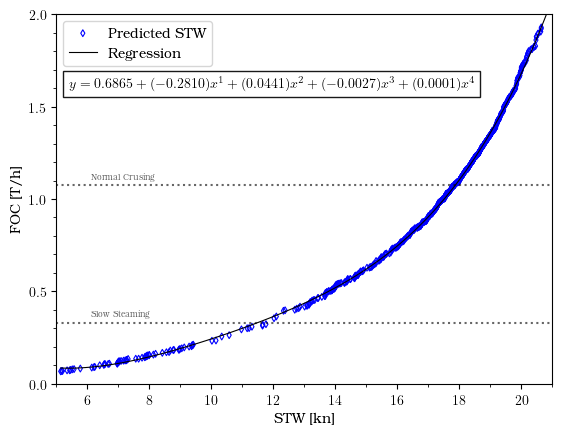

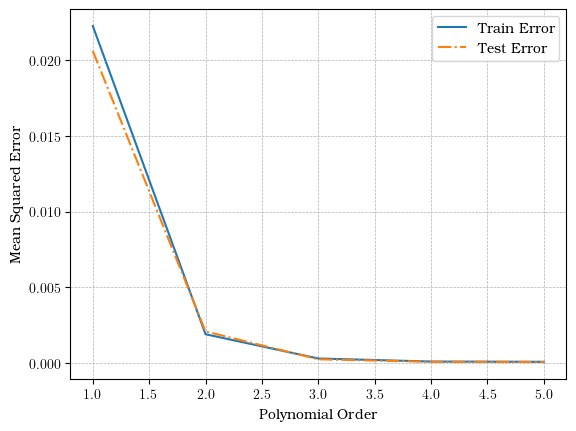

Best Polynomial Equation:
$y = 0.6156 + (-0.2568)x^1 + (0.0412)x^2 + (-0.0026)x^3 + (0.0001)x^4$


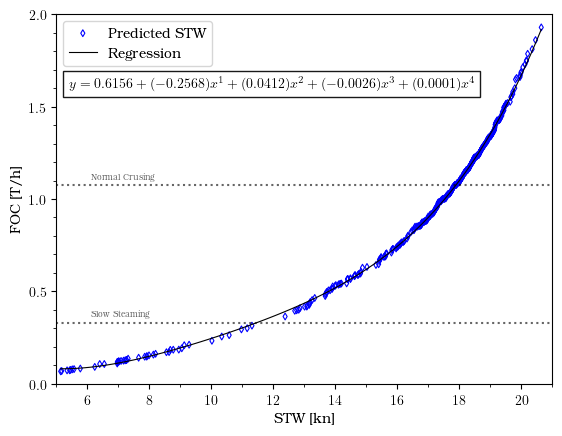

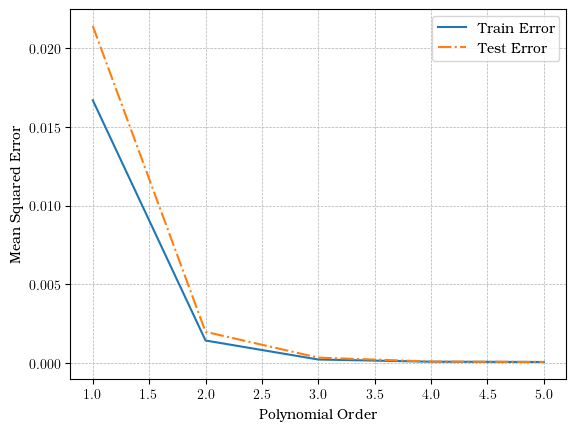

Best Polynomial Equation:
$y = -1.0607 + (0.3176)x^1 + (-0.0279)x^2 + (0.0009)x^3$


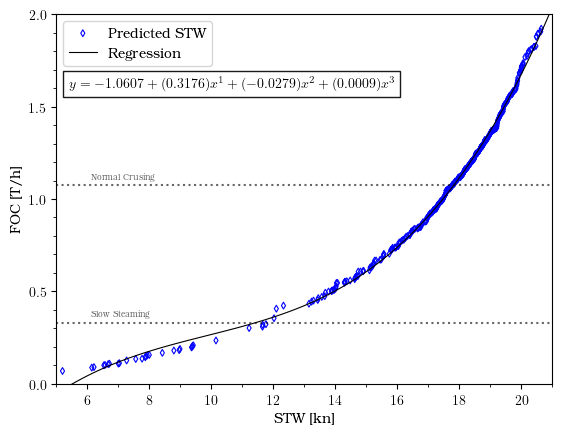

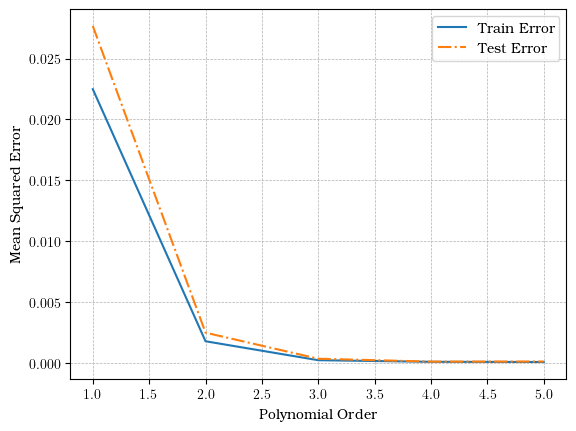

In [290]:
poly_act_yr = poly_reg_best_fit(stw_act_yr,FOC_act_yr)
poly_act_w = poly_reg_best_fit(stw_act_w,FOC_act_w)
poly_act_s = poly_reg_best_fit(stw_act_s,FOC_act_s)

ETR polyfit plot

Best Polynomial Equation:
$y = 0.5953 + (-0.2424)x^1 + (0.0384)x^2 + (-0.0024)x^3 + (0.0001)x^4$


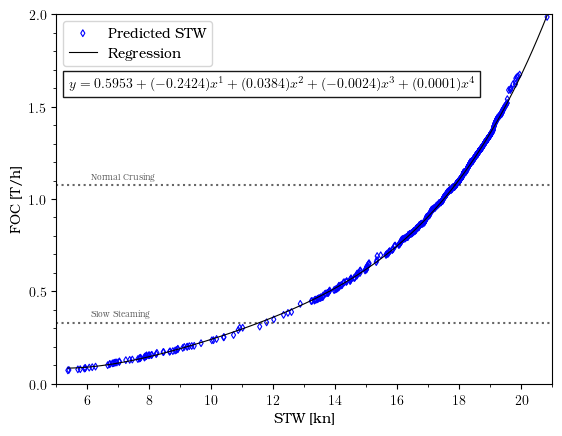

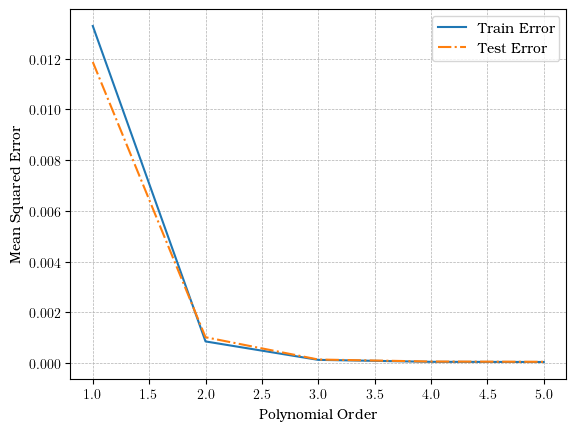

Best Polynomial Equation:
$y = 0.5761 + (-0.2392)x^1 + (0.0386)x^2 + (-0.0024)x^3 + (0.0001)x^4$


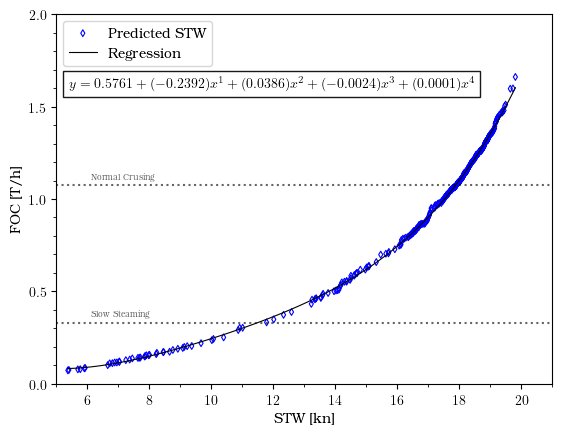

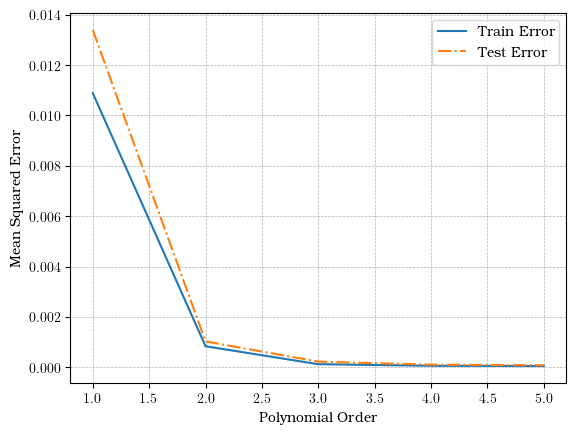

Best Polynomial Equation:
$y = 0.5929 + (-0.2333)x^1 + (0.0361)x^2 + (-0.0022)x^3 + (0.0001)x^4$


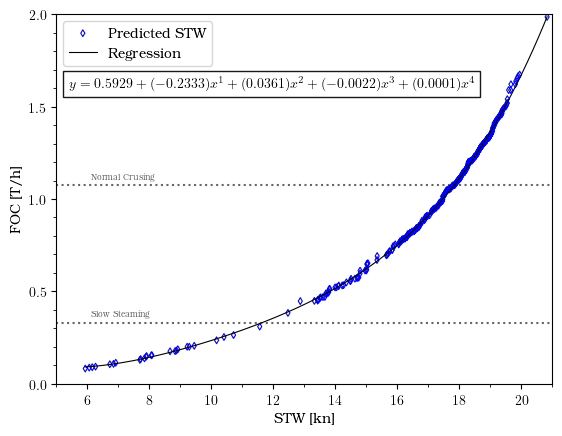

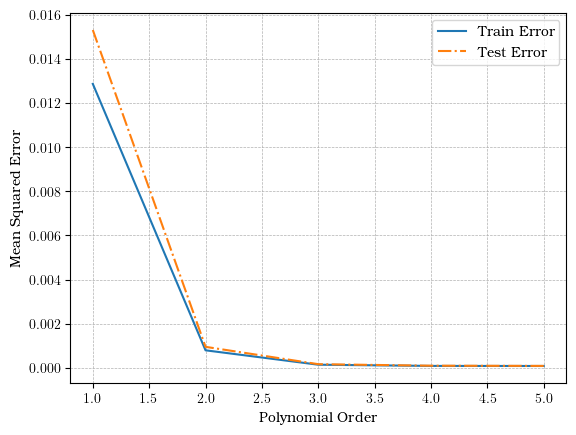

In [291]:
# Yearly data
poly_etr_yr = poly_reg_best_fit(stw_pred_et_yr,FOC_pred_yr)
# Winter data
poly_etr_w = poly_reg_best_fit(stw_pred_et_w,FOC_pred_w)
# Summer data
poly_etr_s = poly_reg_best_fit(stw_pred_et_s,FOC_pred_s)

RFR polyfit FOC

Best Polynomial Equation:
$y = 0.6196 + (-0.2518)x^1 + (0.0397)x^2 + (-0.0024)x^3 + (0.0001)x^4$


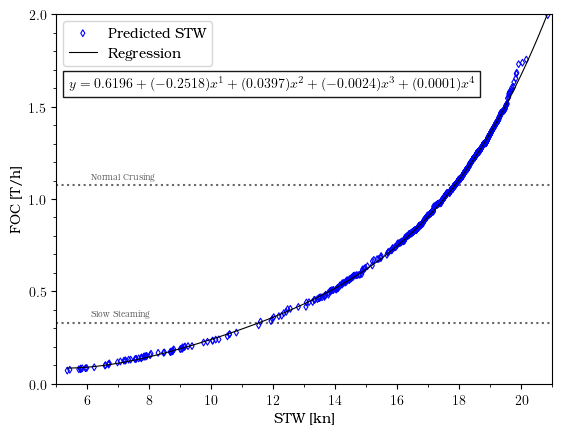

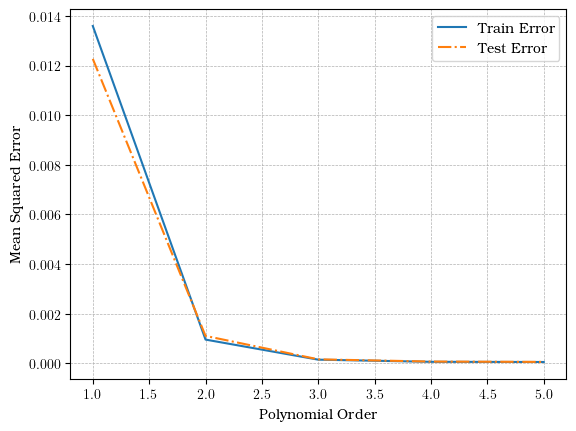

In [292]:
poly_rfr_yr = poly_reg_best_fit(stw_pred_rf_yr,FOC_pred_rf_yr)

Best Polynomial Equation:
$y = 0.5986 + (-0.2476)x^1 + (0.0397)x^2 + (-0.0025)x^3 + (0.0001)x^4$


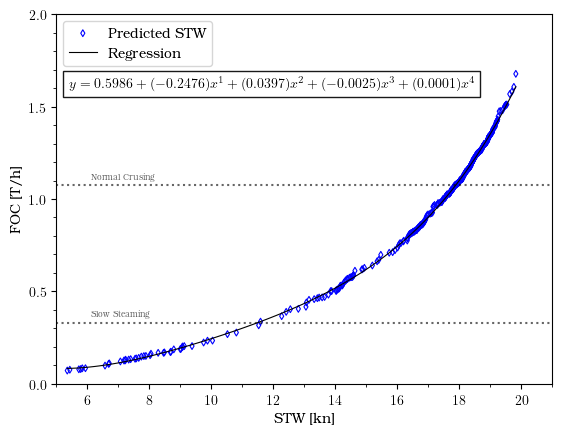

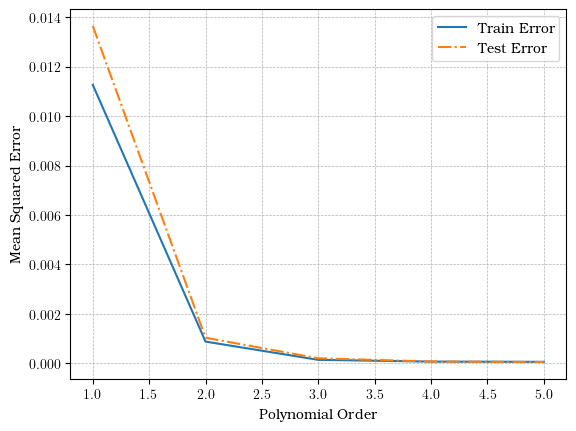

In [293]:
#winter 
poly_rfr_w = poly_reg_best_fit(stw_pred_rf_w,FOC_pred_rf_w)

Best Polynomial Equation:
$y = 0.6077 + (-0.2412)x^1 + (0.0374)x^2 + (-0.0023)x^3 + (0.0001)x^4$


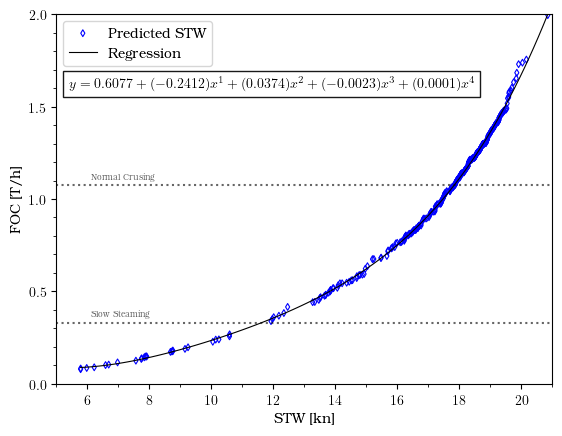

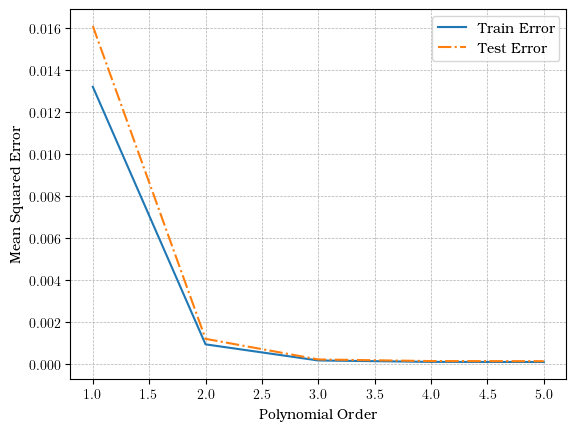

In [294]:
#summer 
poly_rfr_s = poly_reg_best_fit(stw_pred_rf_s,FOC_pred_rf_s)

DTR

Best Polynomial Equation:
$y = 0.6720 + (-0.2719)x^1 + (0.0424)x^2 + (-0.0026)x^3 + (0.0001)x^4$


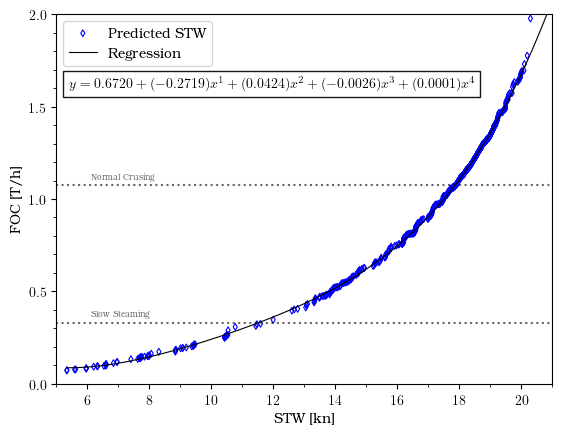

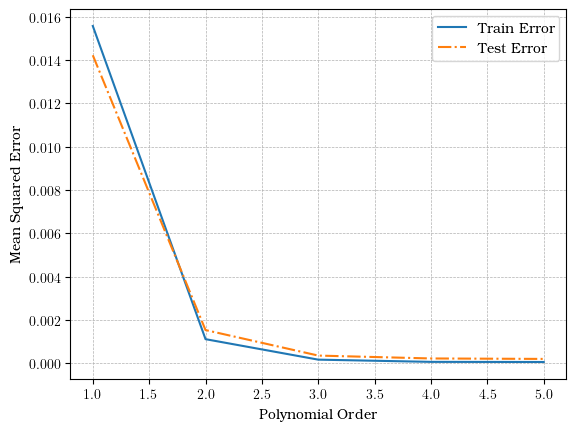

In [295]:
poly_dtr_yr = poly_reg_best_fit(stw_pred_dt_yr,FOC_pred_dt_yr)

Best Polynomial Equation:
$y = 0.6388 + (-0.2623)x^1 + (0.0416)x^2 + (-0.0026)x^3 + (0.0001)x^4$


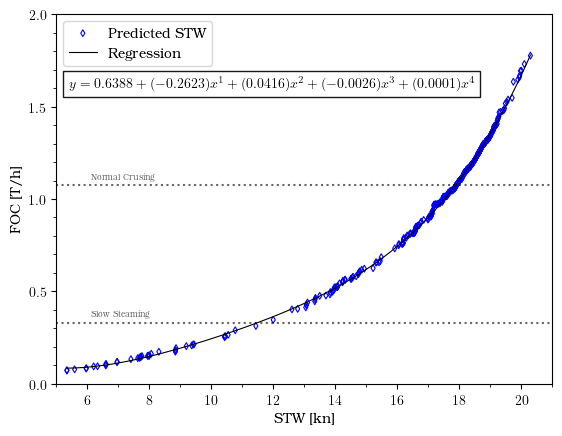

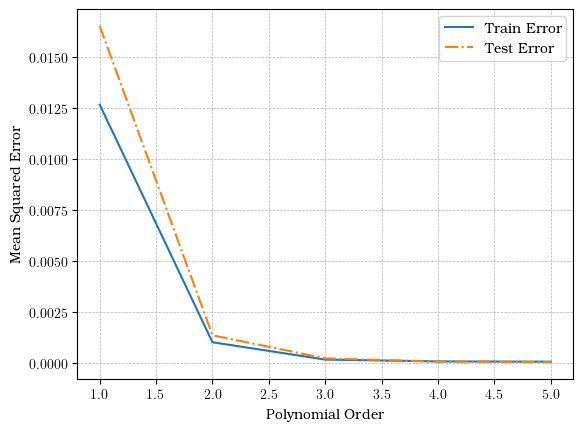

In [296]:
#winter 
poly_dtr_w = poly_reg_best_fit(stw_pred_dt_w,FOC_pred_dt_w)

Best Polynomial Equation:
$y = 0.6571 + (-0.2608)x^1 + (0.0402)x^2 + (-0.0024)x^3 + (0.0001)x^4$


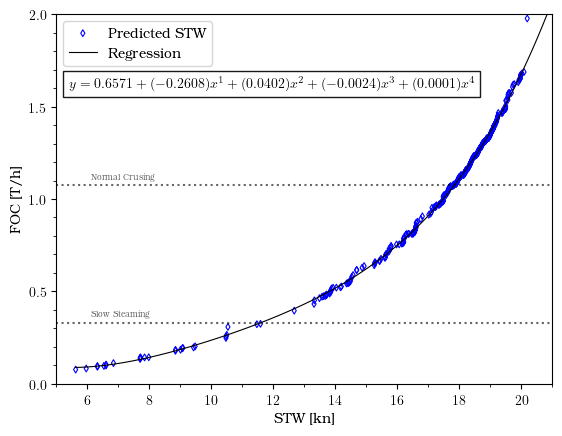

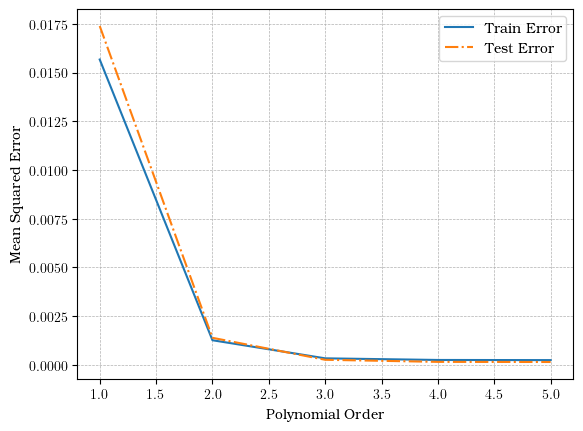

In [297]:
#summer 
poly_dtr_s = poly_reg_best_fit(stw_pred_dt_s,FOC_pred_dt_s)

Absolute model performance

In [298]:
# This function defines the model performance for the given stw range

def evaluate_FOC(model,FOC_act,FOC_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_FOC = r2_score(FOC_act,FOC_pred)
    expVar_FOC = explained_variance_score(FOC_act,FOC_pred)
    MAE_FOC = mean_absolute_error(FOC_act,FOC_pred)
    RMSE_FOC = np.sqrt(mean_squared_error(FOC_act, FOC_pred))
    MAD_FOC = median_absolute_error(FOC_act,FOC_pred)
    MAPE_FOC = mean_absolute_percentage_error(FOC_act, FOC_pred)
    
    print(f"Model Performance of {model}")
    print(f"R^2 {Rsquared_FOC:0.4f}")
    print(f"Explained Variance {expVar_FOC:0.4f}")
    print(f"MAE {MAE_FOC:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_FOC:0.4f} T/h")
    print(f"MAD {MAD_FOC:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_FOC*100:0.4f} %")


ETR

In [299]:
# Yearly performance 

evaluate_FOC(model_etr_hpov,FOC_act_yr,FOC_pred_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.8384
Explained Variance 0.8401
MAE 0.1112 T/h
RMSE FOC 0.1607 T/h
MAD 0.0759 T/h
MAPE FOC 12.4479 %


In [300]:
evaluate_FOC(model_etr_hpov,FOC_act_s,FOC_pred_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.7986
Explained Variance 0.8049
MAE 0.1268 T/h
RMSE FOC 0.1848 T/h
MAD 0.0820 T/h
MAPE FOC 13.6429 %


In [301]:
evaluate_FOC(model_etr_hpov,FOC_act_w,FOC_pred_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.8757
Explained Variance 0.8757
MAE 0.0970 T/h
RMSE FOC 0.1353 T/h
MAD 0.0677 T/h
MAPE FOC 11.3692 %


RFR

In [302]:
# On yearly data

evaluate_FOC(model_rfr_hpov,FOC_act_yr,FOC_pred_rf_yr)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.8182
Explained Variance 0.8189
MAE 0.1167 T/h
RMSE FOC 0.1704 T/h
MAD 0.0786 T/h
MAPE FOC 13.6453 %


In [303]:
evaluate_FOC(model_rfr_hpov,FOC_act_s,FOC_pred_rf_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.7681
Explained Variance 0.7720
MAE 0.1365 T/h
RMSE FOC 0.1983 T/h
MAD 0.0880 T/h
MAPE FOC 15.3718 %


In [304]:
evaluate_FOC(model_rfr_hpov,FOC_act_w,FOC_pred_rf_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.8655
Explained Variance 0.8656
MAE 0.0987 T/h
RMSE FOC 0.1407 T/h
MAD 0.0692 T/h
MAPE FOC 12.0870 %


DTR

In [305]:
evaluate_FOC(model_dtr_hpov,FOC_act_yr,FOC_pred_dt_yr)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.7659
Explained Variance 0.7663
MAE 0.1331 T/h
RMSE FOC 0.1934 T/h
MAD 0.0865 T/h
MAPE FOC 15.7897 %


In [306]:
evaluate_FOC(model_dtr_hpov,FOC_act_s,FOC_pred_dt_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.7442
Explained Variance 0.7473
MAE 0.1445 T/h
RMSE FOC 0.2082 T/h
MAD 0.0967 T/h
MAPE FOC 16.2465 %


In [307]:
evaluate_FOC(model_dtr_hpov,FOC_act_w,FOC_pred_dt_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.7824
Explained Variance 0.7825
MAE 0.1228 T/h
RMSE FOC 0.1790 T/h
MAD 0.0801 T/h
MAPE FOC 15.3774 %


MLR

In [308]:
#yearly data

evaluate_FOC(model_mlr_ftr,FOC_act_yr,FOC_pred_mlr_yr)

Model Performance of LinearRegression()
R^2 0.2934
Explained Variance 0.3203
MAE 0.2231 T/h
RMSE FOC 0.3360 T/h
MAD 0.1714 T/h
MAPE FOC 29.3531 %


In [309]:
evaluate_FOC(model_mlr_ftr,FOC_act_s,FOC_pred_mlr_s)

Model Performance of LinearRegression()
R^2 0.4428
Explained Variance 0.4944
MAE 0.2353 T/h
RMSE FOC 0.3074 T/h
MAD 0.1911 T/h
MAPE FOC 25.2946 %


In [310]:
evaluate_FOC(model_mlr_ftr,FOC_act_w,FOC_pred_mlr_w)

Model Performance of LinearRegression()
R^2 0.1198
Explained Variance 0.1309
MAE 0.2122 T/h
RMSE FOC 0.3600 T/h
MAD 0.1628 T/h
MAPE FOC 33.0163 %


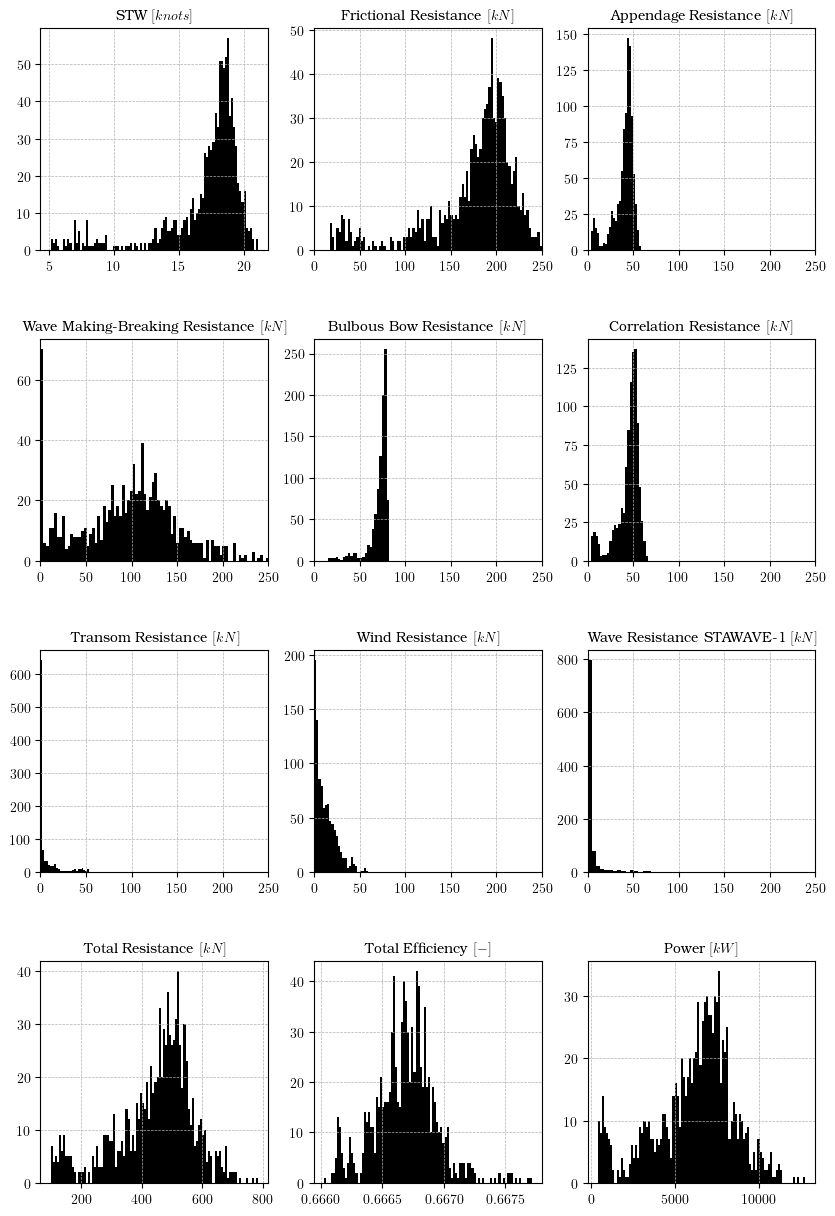

In [311]:
fs = 10

plt.rcParams.update(plt.rcParamsDefault)
# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})


stw = stw_act_yr
R_f = Rf_act_yr/1e3
R_app = R_app_act_yr/1e3
R_w = R_w_act_yr/1e3
R_b = R_b_act_yr/1e3
R_tr = R_tr_act_yr/1e3
R_a = R_a_act_yr/1e3
R_aa = R_aa_act_yr/1e3
# R_aa_hm = dfprog_f['R_aa_hm']/1e3
R_awl = R_awl_act_yr/1e3
R_tot = R_tot_act_yr
# eff_h = dfprog_f['eff_h']
eff_tot = eff_tot_act_yr
P_b = P_b_act_yr
FOC = FOC_act_yr



fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

axes[0, 0].hist(stw,bins=100,color='black')
axes[0, 0].set_title(r'STW $[knots]$', fontsize=fs)
axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 1].hist(R_f,bins=100,color='black')
axes[0, 1].set_title(r'Frictional Resistance $[kN]$', fontsize=fs)
axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[0, 1].set_xlim(0,250)

axes[0, 2].hist(R_app,bins=25,color='black')
axes[0, 2].set_title(r'Appendage Resistance $[kN]$', fontsize=fs)
axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[0, 2].set_xlim(0,250)

axes[1, 0].hist(R_w,bins=100,color='black')
axes[1, 0].set_title(r'Wave Making-Breaking Resistance $[kN]$', fontsize=fs)
axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 0].set_xlim(0,250)

axes[1, 1].hist(R_b  ,bins=25,color='black')
axes[1, 1].set_title(r'Bulbous Bow Resistance $[kN]$', fontsize=fs)
axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 1].set_xlim(0,250)

axes[1, 2].hist(R_a,bins=25,color='black')
axes[1, 2].set_title(r'Correlation Resistance $[kN]$', fontsize=fs)
axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 2].set_xlim(0,250)

axes[2, 1].hist(R_aa,bins=25,color='black')
axes[2, 1].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 1].set_xlim(0,250)

# axes[2, 0].hist(R_aa_hm,bins=25,color='black')
# axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
# axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 2].hist(R_awl,bins=25,color='black')
axes[2, 2].set_title(r'Wave Resistance STAWAVE-1 $[kN]$', fontsize=fs)
axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 2].set_xlim(0,250)

axes[2, 0].hist(R_tr,bins=25,color='black')
axes[2, 0].set_title(r'Transom Resistance $[kN]$', fontsize=fs)
axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 0].set_xlim(0,250)

axes[3, 0].hist(R_tot,bins=100,color='black')
axes[3, 0].set_title(r'Total Resistance $[kN]$', fontsize=fs)
axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 0].hist(eff_h,bins=25,color='black')
# axes[3, 0].set_title(r'Hull Efficiency $[-]$', fontsize=fs)
# axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 1].hist(eff_tot,bins=100,color='black')
axes[3, 1].set_title(r'Total Efficiency $[-]$', fontsize=fs)
axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 2].hist(P_b,bins=100,color='black')
axes[3, 2].set_title(r'Power $[kW]$', fontsize=fs)
axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[4, 1].hist(FOC,bins=25,color='black')
# axes[4, 1].set_title(r'Fuel Consumption $[t/h]$', fontsize=fs)
# axes[4, 1].grid(True,linestyle = '--', linewidth = 0.5)

fig.subplots_adjust(hspace=0.4)
plt.show()

In [312]:
def FOC_plot_yr(FOC_actual_yr,FOC_ETR_yr,FOC_RFR_yr,FOC_DTR_yr):
    rmse_opt = [FOC_actual_yr,FOC_ETR_yr,FOC_RFR_yr,FOC_DTR_yr]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("FOC comparison for yearly data")
    plt.ylabel("FOC [T/h]")
    plt.xlabel("Period")
    plt.yscale('linear')
    ax.boxplot(rmse_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'$FOC_{actual}$', r'$FOC_{ETR}$',
                        r'$FOC_{RFR}$', r'$FOC_{DTR}$'])

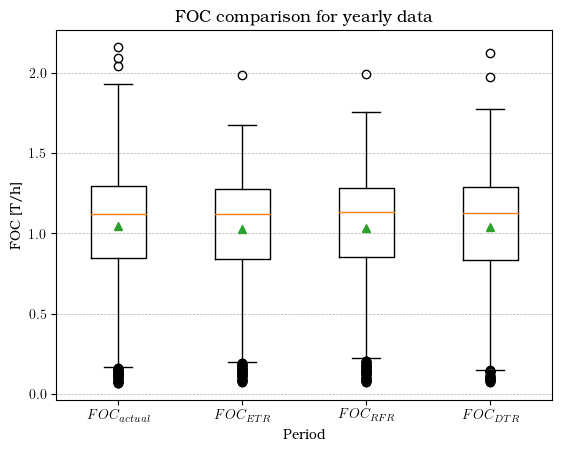

In [313]:
FOC_plot_yr(FOC_act_yr,FOC_pred_yr,FOC_pred_rf_yr,FOC_pred_dt_yr)
plt.show()

Polyfit Evaluations

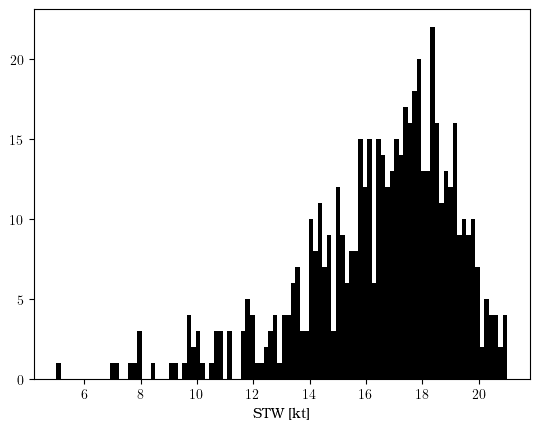

In [314]:
import random
from sklearn.preprocessing import PolynomialFeatures

# # Simulate model performance by inserting arbitrary STW in knots

# Skewed distribution of random numbers

# Set the seed for reproducibility
seed_value = 0
np.random.seed(seed_value)

# Parameters for the right-skewed normal distribution
mean = 17  # Mean of the distribution
std_dev = -3.176740  # Standard deviation of the distribution
skewness_factor = .4  # Skewness factor to control the skewness

# Range of the random numbers you want to generate
minimum = 5
maximum = 21

# Generate random numbers with a standard normal distribution
n = 558  # Number of random numbers to generate
standard_normal_values = np.random.randn(n)

# Transform the standard normal distribution into a right-skewed distribution
right_skewed_values = mean + std_dev * np.exp(skewness_factor * standard_normal_values)

# Scale and shift the values to the desired range
scaled_values = (right_skewed_values - np.min(right_skewed_values)) / (np.max(right_skewed_values) - np.min(right_skewed_values))
v_stw = minimum + scaled_values * (maximum - minimum)
v_stw = v_stw.reshape(-1,1)
plt.hist(v_stw,bins=100,color='black')
plt.xlabel('STW [kt]')
plt.show()
poly_stw = PolynomialFeatures(degree=4)
poly_stw3 = PolynomialFeatures(degree=3)
stw_poly = poly_stw.fit_transform(v_stw)
stw_poly3 = poly_stw3.fit_transform(v_stw)

In [315]:
# This model defines the performance of the generated polyfit line from the model

def evaluate_FOC_poly(model,FOC_poly_act,FOC_poly_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_ply = r2_score(FOC_poly_act,FOC_poly_pred)
    expVar_ply = explained_variance_score(FOC_poly_act,FOC_poly_pred)
    MAE_ply = mean_absolute_error(FOC_poly_act,FOC_poly_pred)
    RMSE_ply = np.sqrt(mean_squared_error(FOC_poly_act,FOC_poly_pred))
    MAD_ply = median_absolute_error(FOC_poly_act,FOC_poly_pred)
    MAPE_ply = mean_absolute_percentage_error(FOC_poly_act,FOC_poly_pred)
    
    print(f"Model Performance of {model}")
    print(f"R^2 {Rsquared_ply:0.4f}")
    print(f"Explained Variance {expVar_ply:0.4f}")
    print(f"MAE {MAE_ply:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_ply:0.4f} T/h")
    print(f"MAD {MAD_ply:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_ply*100:0.4f} %")

On year datasets

In [316]:
FOC_act_ply_yr = poly_act_yr.predict(stw_poly)
# Test on different tree based model
FOC_etr_ply_yr = poly_etr_yr.predict(stw_poly)
FOC_rfr_ply_yr = poly_rfr_yr.predict(stw_poly)
FOC_dtr_ply_yr = poly_dtr_yr.predict(stw_poly)
# Evaluate performance 
evaluate_FOC_poly(model_etr_hpov,FOC_act_ply_yr,FOC_etr_ply_yr)
evaluate_FOC_poly(model_rfr_hpov,FOC_act_ply_yr,FOC_rfr_ply_yr)
evaluate_FOC_poly(model_dtr_hpov,FOC_act_ply_yr,FOC_dtr_ply_yr)


Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.9999
Explained Variance 0.9999
MAE 0.0022 T/h
RMSE FOC 0.0032 T/h
MAD 0.0020 T/h
MAPE FOC 0.2820 %
Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 1.0000
Explained Variance 1.0000
MAE 0.0019 T/h
RMSE FOC 0.0026 T/h
MAD 0.0016 T/h
MAPE FOC 0.2445 %
Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 1.0000
Explained Variance 1.0000
MAE 0.0011 T/h
RMSE FOC 0.0014 T/h
MAD 0.0010 T/h
MAPE FOC 0.1574 %


On Winter datasets

In [317]:
FOC_act_ply_w = poly_act_w.predict(stw_poly)
# Test on different tree based model
FOC_etr_ply_w = poly_etr_w.predict(stw_poly)
FOC_rfr_ply_w = poly_rfr_w.predict(stw_poly)
FOC_dtr_ply_w = poly_dtr_w.predict(stw_poly)
# Evaluate performance 
evaluate_FOC_poly(model_etr_hpov,FOC_act_ply_w,FOC_etr_ply_w)
evaluate_FOC_poly(model_rfr_hpov,FOC_act_ply_w,FOC_rfr_ply_w)
evaluate_FOC_poly(model_dtr_hpov,FOC_act_ply_w,FOC_dtr_ply_w)


Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 1.0000
Explained Variance 1.0000
MAE 0.0011 T/h
RMSE FOC 0.0014 T/h
MAD 0.0012 T/h
MAPE FOC 0.1537 %
Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 1.0000
Explained Variance 1.0000
MAE 0.0009 T/h
RMSE FOC 0.0011 T/h
MAD 0.0008 T/h
MAPE FOC 0.1285 %
Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 1.0000
Explained Variance 1.0000
MAE 0.0006 T/h
RMSE FOC 0.0007 T/h
MAD 0.0006 T/h
MAPE FOC 0.1125 %


On Summer Datasets

In [319]:
# Special case for summer, since best model is power 3 
FOC_act_ply_s = poly_act_s.predict(stw_poly3)
# Test on different tree based model
FOC_etr_ply_s = poly_etr_s.predict(stw_poly)
FOC_rfr_ply_s = poly_rfr_s.predict(stw_poly)
FOC_dtr_ply_s = poly_dtr_s.predict(stw_poly)
# Evaluate performance 
evaluate_FOC_poly(model_etr_hpov,FOC_act_ply_s,FOC_etr_ply_s)
evaluate_FOC_poly(model_rfr_hpov,FOC_act_ply_s,FOC_rfr_ply_s)
evaluate_FOC_poly(model_dtr_hpov,FOC_act_ply_s,FOC_dtr_ply_s)


Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.9991
Explained Variance 0.9991
MAE 0.0090 T/h
RMSE FOC 0.0126 T/h
MAD 0.0073 T/h
MAPE FOC 2.1262 %
Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.9991
Explained Variance 0.9991
MAE 0.0090 T/h
RMSE FOC 0.0126 T/h
MAD 0.0070 T/h
MAPE FOC 2.1148 %
Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.9990
Explained Variance 0.9991
MAE 0.0089 T/h
RMSE FOC 0.0127 T/h
MAD 0.0066 T/h
MAPE FOC 2.0916 %
